In [78]:
import pandas as pd
from google.colab import files

# Upload the CSV file
uploaded = files.upload()

Saving modified_file.csv to modified_file (6).csv


In [79]:
df = pd.read_csv("modified_file.csv")
df.tail(3)

OPC (Kg/m³)  Fine agg (Kg/m³)  Coarse agg (Kg/m³)  Fly ash (Kg/m³)  \
246        555.0             968.0               720.0              0.0   
247        525.0             972.0               718.0              0.0   
248        470.0             970.0               715.0              0.0   

     Silica fume (Kg/m³)  Marble powder (Kg/m³)  Water (Kg/m³)  \
246                  0.0                    0.0          180.0   
247                 30.0                    0.0          182.0   
248                 25.0                   50.0          183.0   

     Superplasticizer (Kg/m³)  Curing age (days)  Compressive strength (Mpa)  
246                       7.5                  7                        40.2  
247                       8.0                  7                        45.3  
248                       6.1                  7                        48.0

In [80]:
!pip install -q catboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


# Encode non-numeric columns (if any)
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Separate features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]


# Tree-based models used here do not require feature normalization/scaling.

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Models and hyperparameters
param_grids = {
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 6, 9]
    },
    "XGBoost": {
        'learning_rate': [0.1],
        'max_depth': [4],
        'reg_alpha': [0.1],
        'reg_lambda': [0.001],
        'n_estimators': [100]
    },
    "LightGBM": {
        'learning_rate': [0.1],
        'max_depth': [4],
        'subsample': [0.5],
        'n_estimators': [100],
        'num_leaves': [31],
        'min_data_in_leaf': [10],
        'boosting_type': ['gbdt'],
         'verbose':[-1]
    },
    "CatBoost": {
        'iterations': [100],
        'learning_rate': [0.1],
        'depth': [4, 6, 8]
    }
}
models = {
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor(use_label_encoder=False, eval_metric='rmse'),
    "LightGBM": LGBMRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0)
}

In [81]:
from sklearn.model_selection import cross_val_score

def evaluate_model_with_cv(model_name, model, param_grid, X_train, y_train, X_test, y_test):
    print(f"Evaluating {model_name}...")

    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=10,
        n_jobs=-1,
        scoring='neg_mean_squared_error',
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Cross-validation RMSE (10-fold)
    cv_rmse_scores = np.sqrt(-cross_val_score(best_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # Cross-validation R² (10-fold)
    cv_r2_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='r2')
    cv_r2_mean = cv_r2_scores.mean()
    cv_r2_std = cv_r2_scores.std()


    # Predictions on test set
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    ss_tot = np.sum((y_test - np.mean(y_test))**2)
    ss_res = np.sum((y_test - y_pred)**2)
    ce = 1 - (ss_res / ss_tot)

    print(f"Best Hyperparameters: {best_params}")
    print(f"CV RMSE Mean: {cv_rmse_mean:.4f}, CV RMSE Std: {cv_rmse_std:.4f}")
    print(f"CV R² Mean: {cv_r2_mean:.4f}, CV R² Std: {cv_r2_std:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R² Score: {r2:.4f}")
    print(f"CE: {ce:.4f}")
    print('-'*60)

    return {
        'Best Model': best_model,
        'Best Params': best_params,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R² Score': r2,
        'CE': ce,
        'CV RMSE Mean': cv_rmse_mean,
        'CV RMSE Std': cv_rmse_std,
        'CV R² Mean': cv_r2_mean,
        'CV R² Std': cv_r2_std
    }

In [82]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


# Run evaluation for all models
results = {}
for model_name, model in models.items():
    param_grid = param_grids.get(model_name, {})
    results[model_name] = evaluate_model_with_cv(model_name, model, param_grid, X_train, y_train, X_test, y_test)

Evaluating Gradient Boosting...
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
CV RMSE Mean: 2.3921, CV RMSE Std: 0.5711
CV R² Mean: 0.9489, CV R² Std: 0.0261
Test MAE: 1.7468
Test RMSE: 2.2196
Test R² Score: 0.9630
CE: 0.9630
------------------------------------------------------------
Evaluating XGBoost...
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.001}
CV RMSE Mean: 2.9884, CV RMSE Std: 0.7158
CV R² Mean: 0.9201, CV R² Std: 0.0427
Test MAE: 1.9897
Test RMSE: 2.6479
Test R² Score: 0.9474
CE: 0.9474
------------------------------------------------------------
Evaluating LightGBM...
Best Hyperparameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 4, 'min_data_in_leaf': 10, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.5, 'verbose': -1}
CV RMSE Mean: 2.9543, CV RMSE Std: 0.6160
CV R² Mean: 0.9212, CV R² Std: 0.0460
Test MAE: 1.9138
Test RMSE: 2.5267
Test 

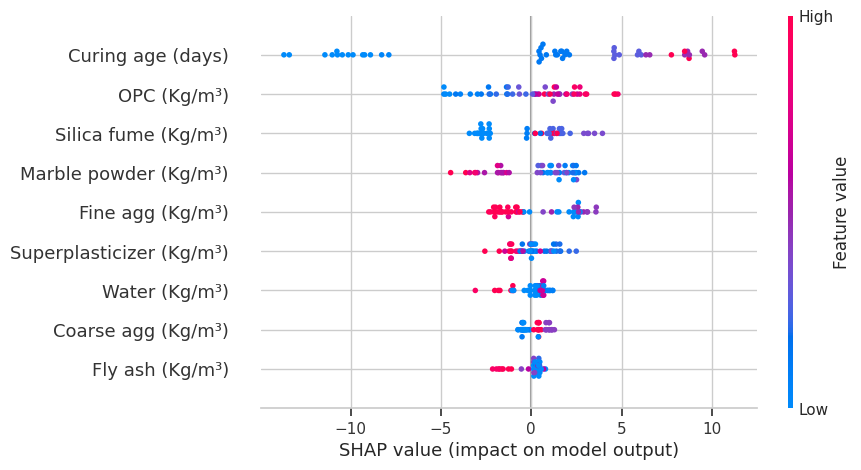

<Figure size 640x480 with 0 Axes>

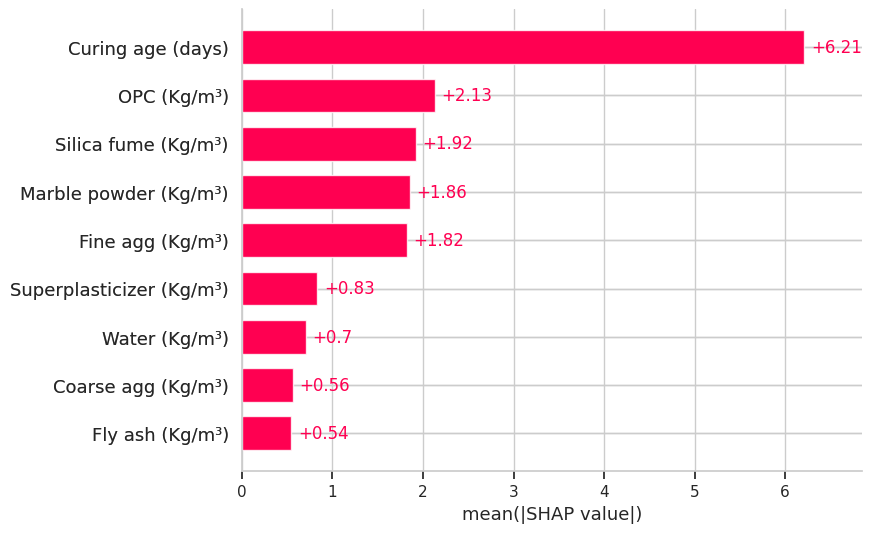

<Figure size 640x480 with 0 Axes>

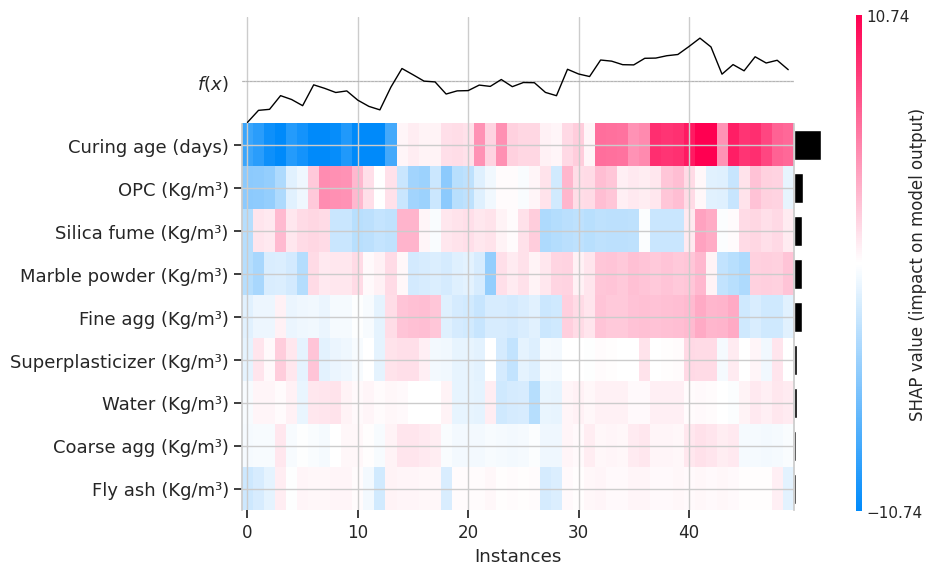

<Figure size 640x480 with 0 Axes>

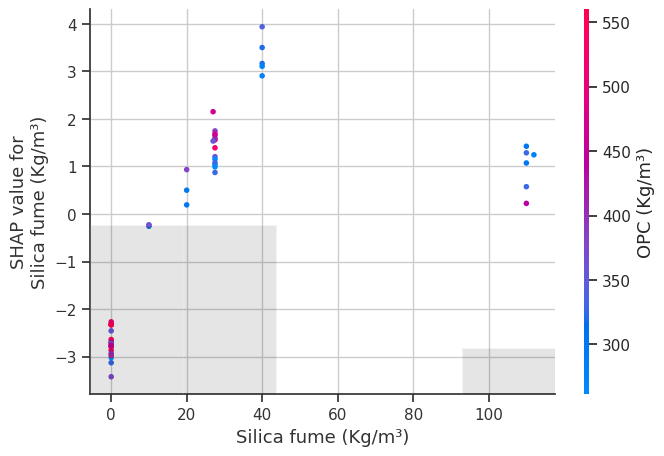

<Figure size 640x480 with 0 Axes>

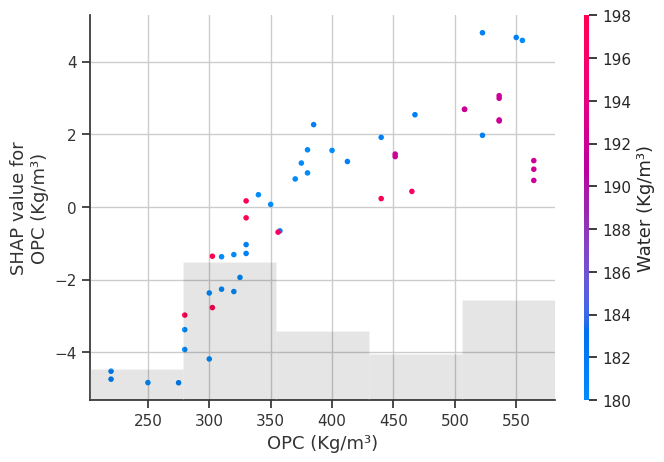

<Figure size 640x480 with 0 Axes>

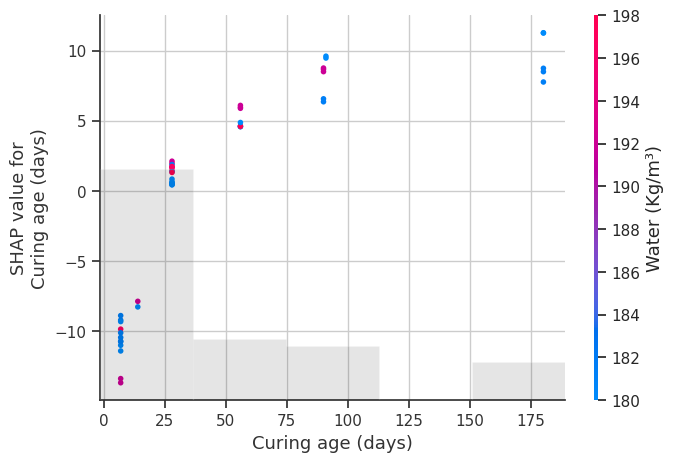

<Figure size 640x480 with 0 Axes>

In [83]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Use TreeExplainer for tree-based models
modelname = "Gradient Boosting"

explainer = shap.Explainer(results[modelname]["Best Model"])
shap_values = explainer(X_test)

# 1. SHAP Summary Plot
shap.plots.beeswarm(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 2. SHAP Bar plot (mean absolute SHAP values)
shap.plots.bar(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 3. SHAP Heatmap
shap.plots.heatmap(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 4. SHAP Dependence Plot (for top 3 features)
top_features = np.argsort(np.abs(shap_values.values).mean(0))[-3:]
for i in top_features:
    shap.plots.scatter(shap_values[:, i], color=shap_values)
    plt.subplots_adjust(hspace=0.5)  # Add vertical gap
    plt.tight_layout()
    plt.show()


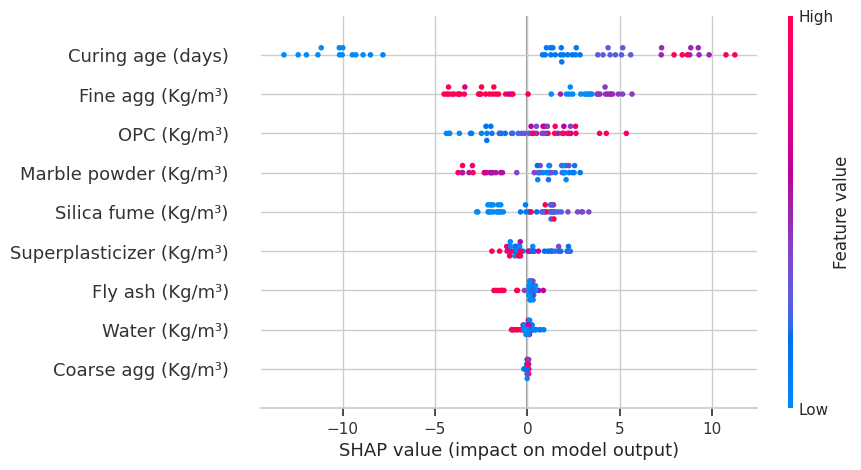

<Figure size 640x480 with 0 Axes>

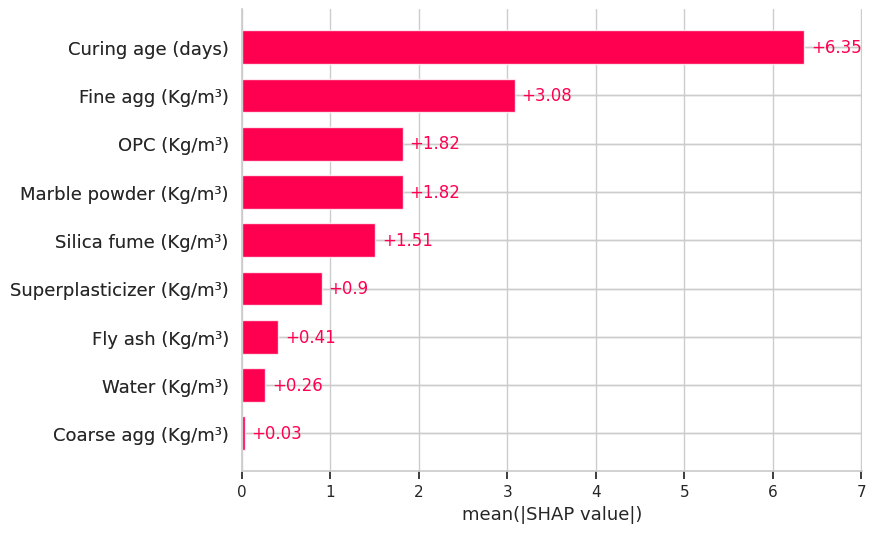

<Figure size 640x480 with 0 Axes>

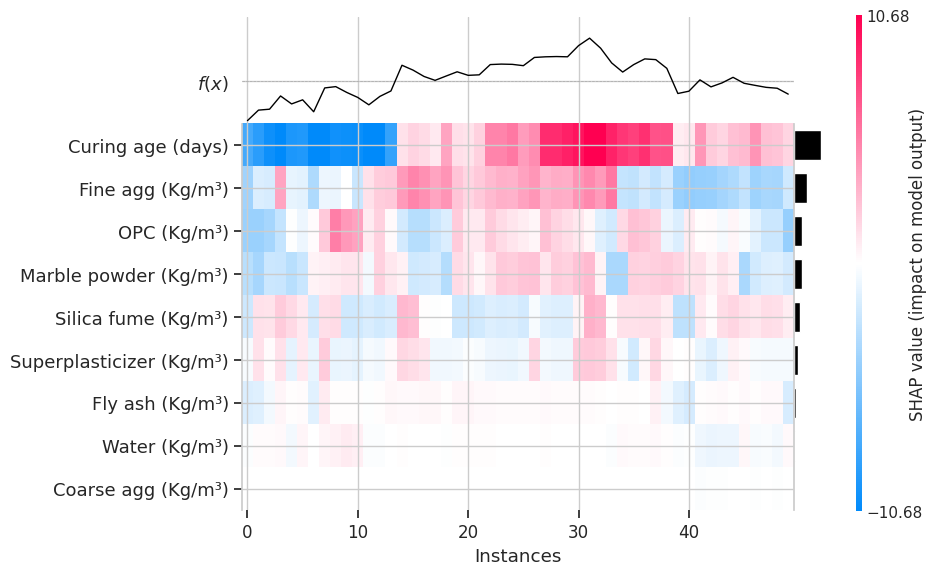

<Figure size 640x480 with 0 Axes>

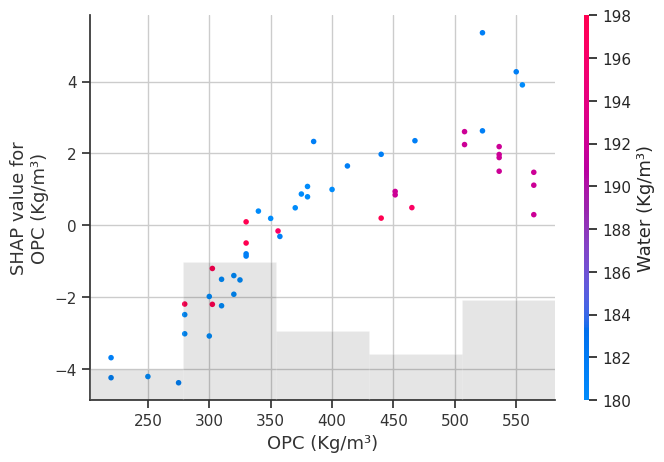

<Figure size 640x480 with 0 Axes>

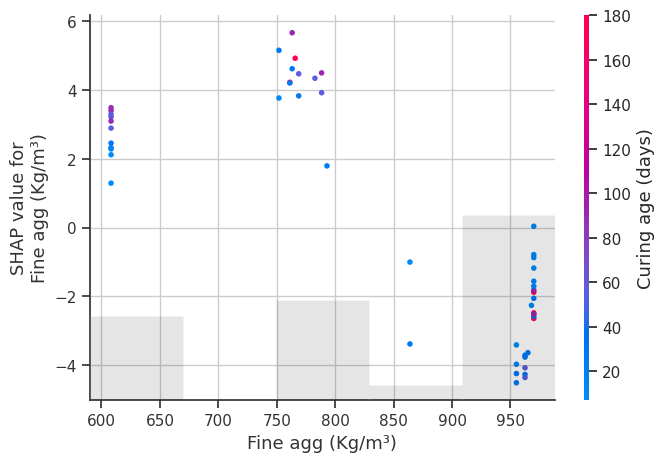

<Figure size 640x480 with 0 Axes>

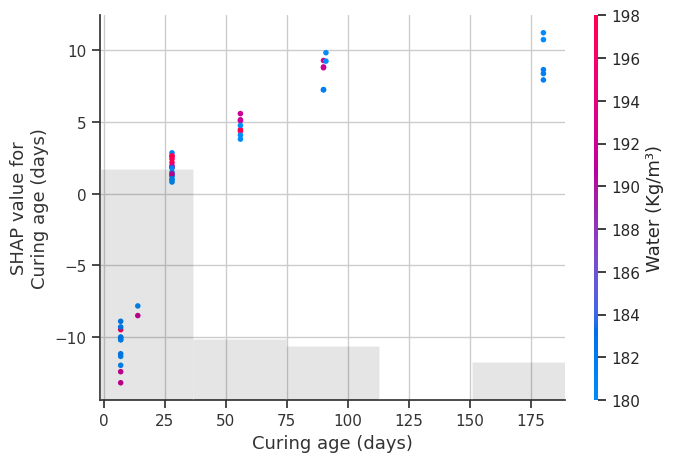

<Figure size 640x480 with 0 Axes>

In [84]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Use TreeExplainer for tree-based models
explainer = shap.Explainer(results["XGBoost"]["Best Model"])
shap_values = explainer(X_test)

# 1. SHAP Summary Plot
shap.plots.beeswarm(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 2. SHAP Bar plot (mean absolute SHAP values)
shap.plots.bar(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 3. SHAP Heatmap
shap.plots.heatmap(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 4. SHAP Dependence Plot (for top 3 features)
top_features = np.argsort(np.abs(shap_values.values).mean(0))[-3:]
for i in top_features:
    shap.plots.scatter(shap_values[:, i], color=shap_values)
    plt.subplots_adjust(hspace=0.5)  # Add vertical gap
    plt.tight_layout()
    plt.show()

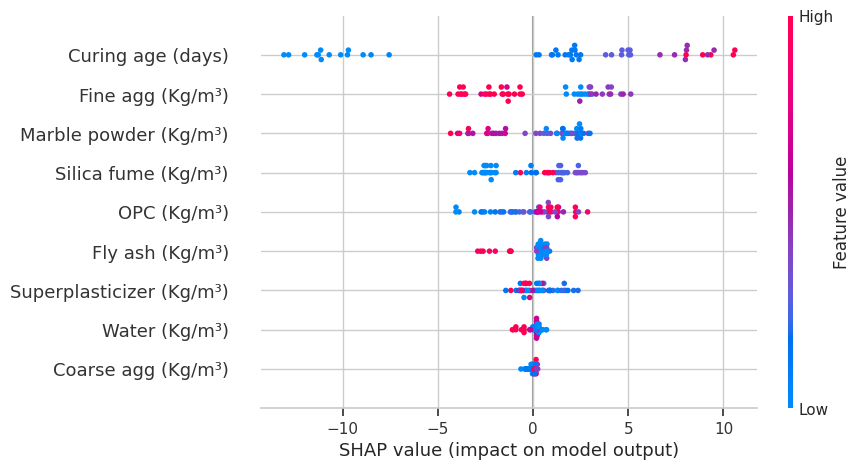

<Figure size 640x480 with 0 Axes>

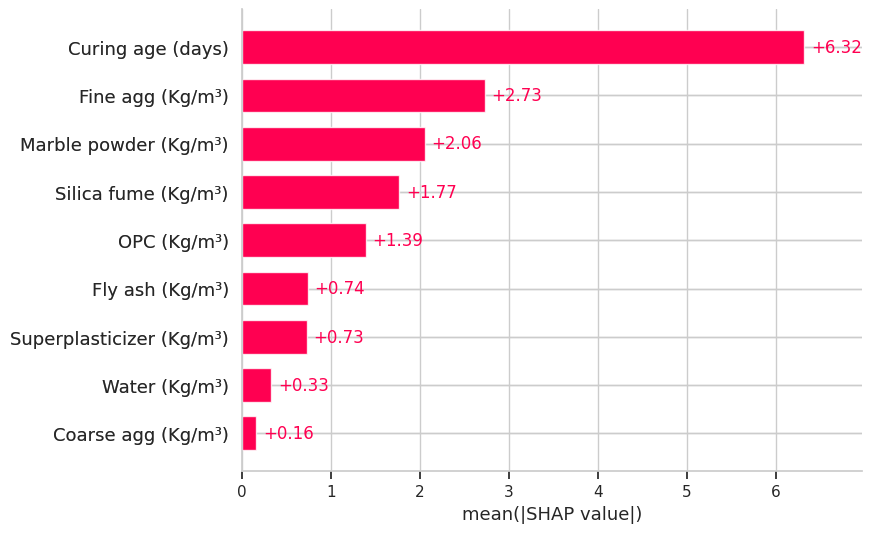

<Figure size 640x480 with 0 Axes>

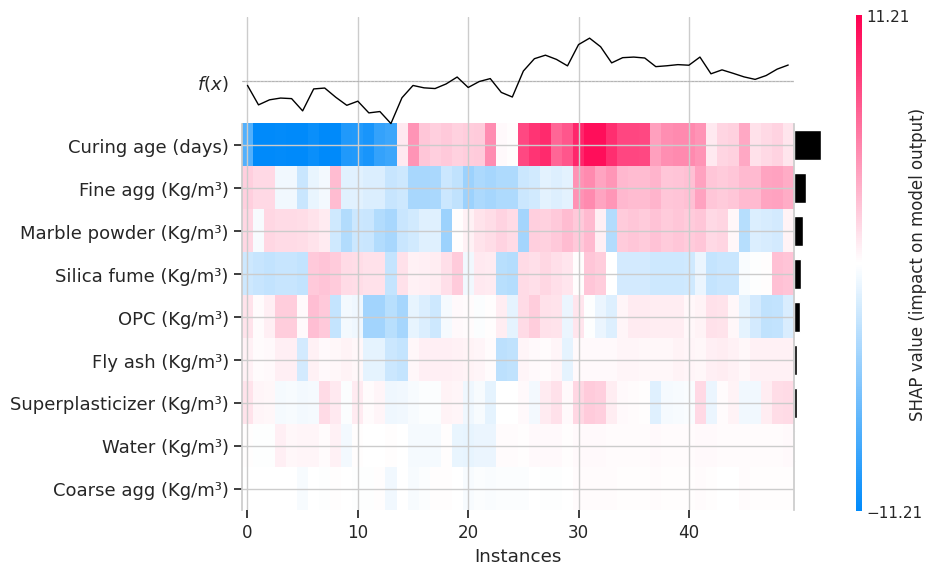

<Figure size 640x480 with 0 Axes>

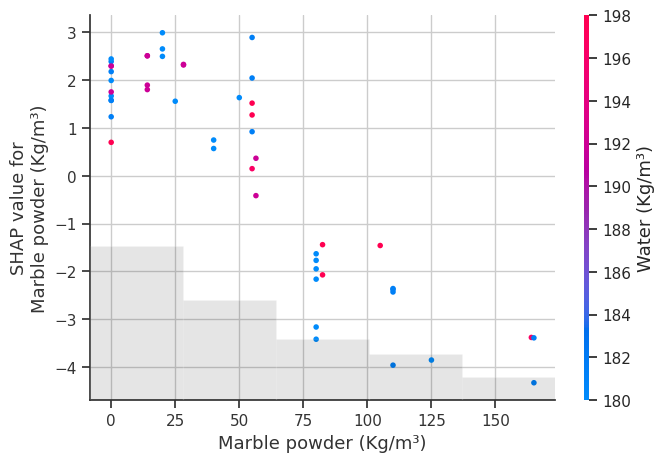

<Figure size 640x480 with 0 Axes>

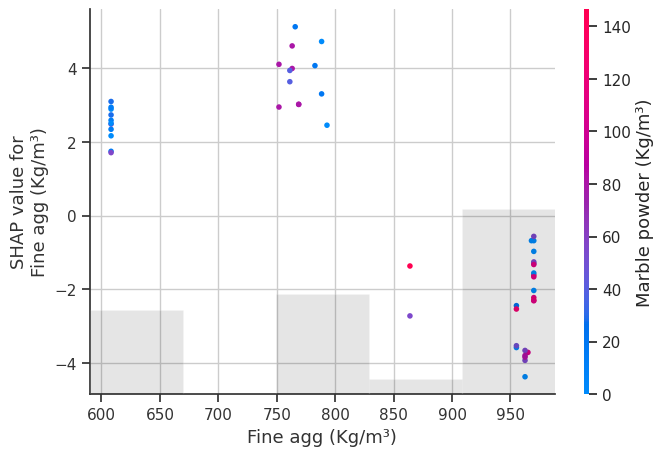

<Figure size 640x480 with 0 Axes>

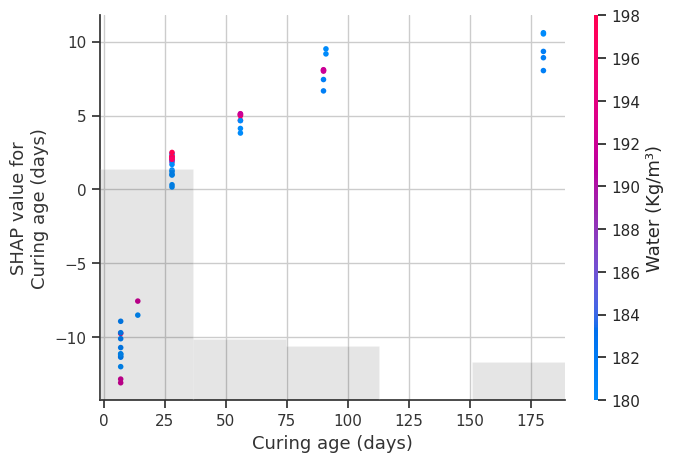

<Figure size 640x480 with 0 Axes>

In [85]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Use TreeExplainer for tree-based models
explainer = shap.Explainer(results["LightGBM"]["Best Model"])
shap_values = explainer(X_test)

# 1. SHAP Summary Plot
shap.plots.beeswarm(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 2. SHAP Bar plot (mean absolute SHAP values)
shap.plots.bar(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 3. SHAP Heatmap
shap.plots.heatmap(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 4. SHAP Dependence Plot (for top 3 features)
top_features = np.argsort(np.abs(shap_values.values).mean(0))[-3:]
for i in top_features:
    shap.plots.scatter(shap_values[:, i], color=shap_values)
    plt.subplots_adjust(hspace=0.5)  # Add vertical gap
    plt.tight_layout()
    plt.show()

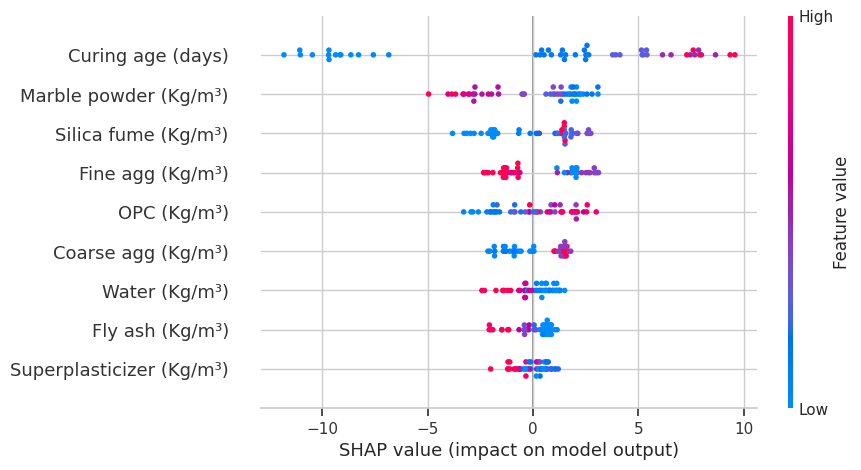

<Figure size 640x480 with 0 Axes>

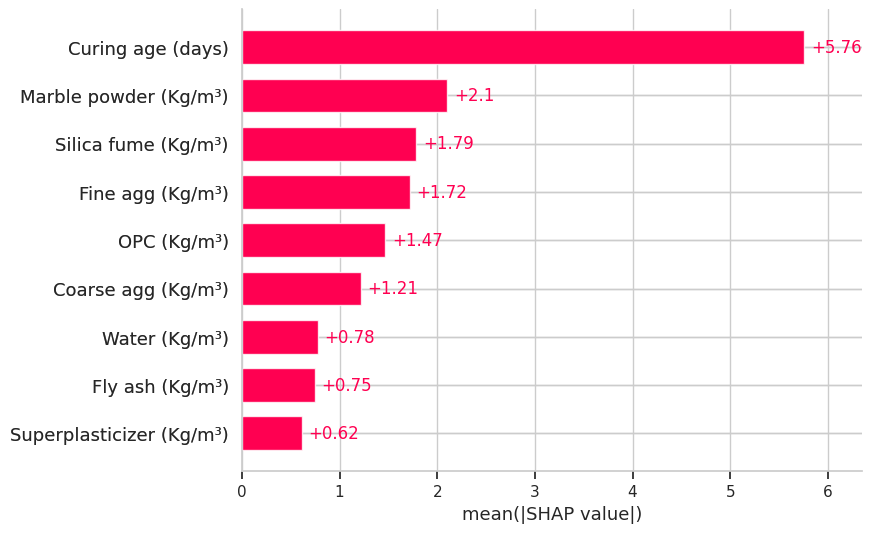

<Figure size 640x480 with 0 Axes>

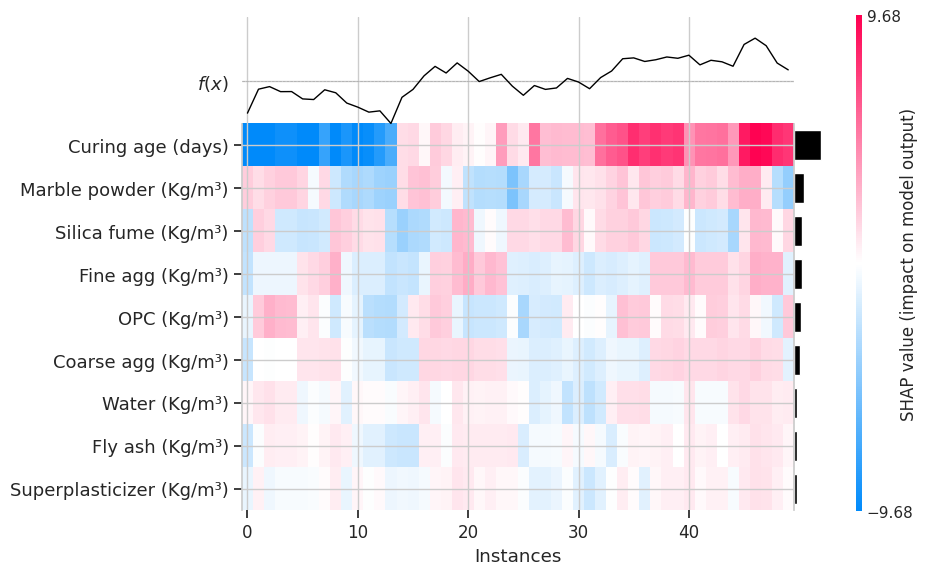

<Figure size 640x480 with 0 Axes>

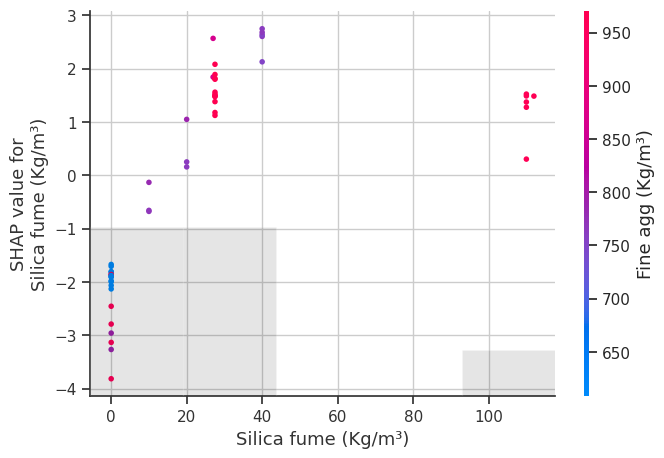

<Figure size 640x480 with 0 Axes>

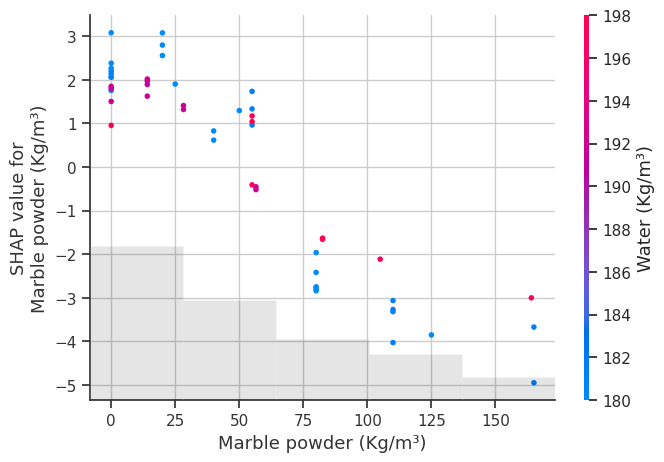

<Figure size 640x480 with 0 Axes>

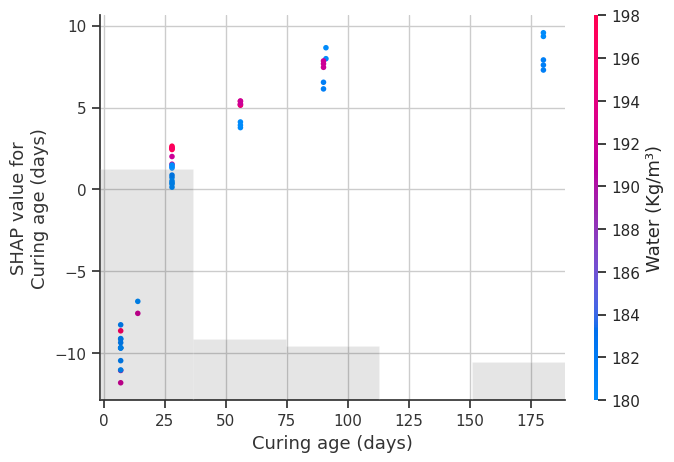

<Figure size 640x480 with 0 Axes>

In [86]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Use TreeExplainer for tree-based models
explainer = shap.Explainer(results["CatBoost"]["Best Model"])
shap_values = explainer(X_test)

# 1. SHAP Summary Plot
shap.plots.beeswarm(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 2. SHAP Bar plot (mean absolute SHAP values)
shap.plots.bar(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 3. SHAP Heatmap
shap.plots.heatmap(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 4. SHAP Dependence Plot (for top 3 features)
top_features = np.argsort(np.abs(shap_values.values).mean(0))[-3:]
for i in top_features:
    shap.plots.scatter(shap_values[:, i], color=shap_values)
    plt.subplots_adjust(hspace=0.5)  # Add vertical gap
    plt.tight_layout()
    plt.show()

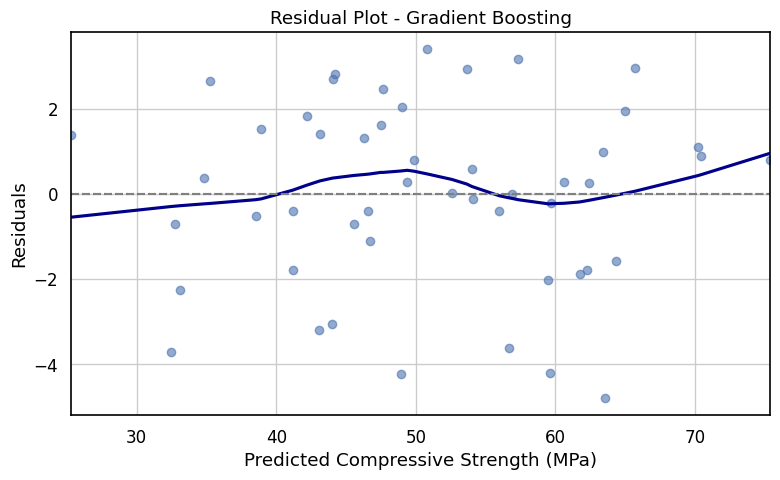

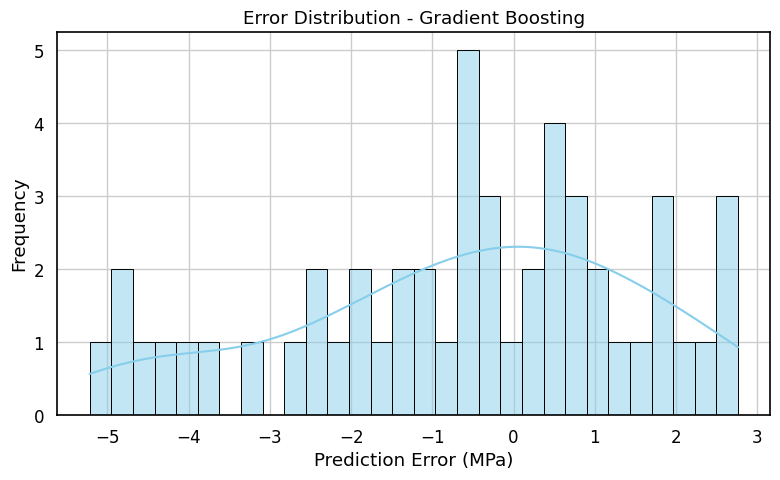

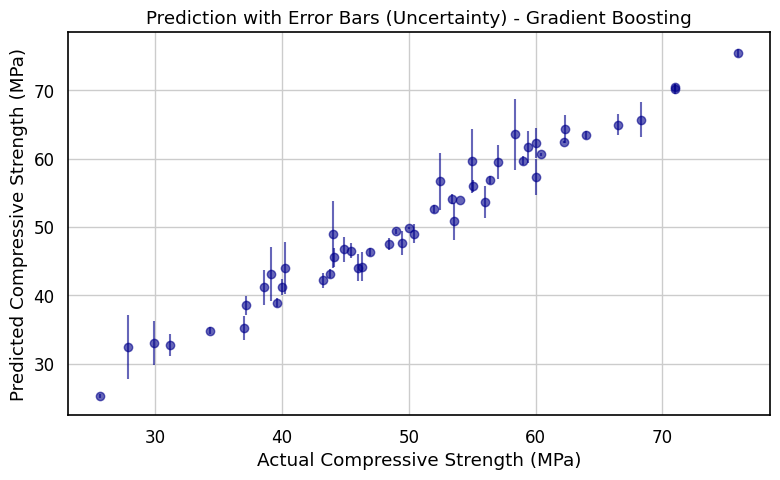

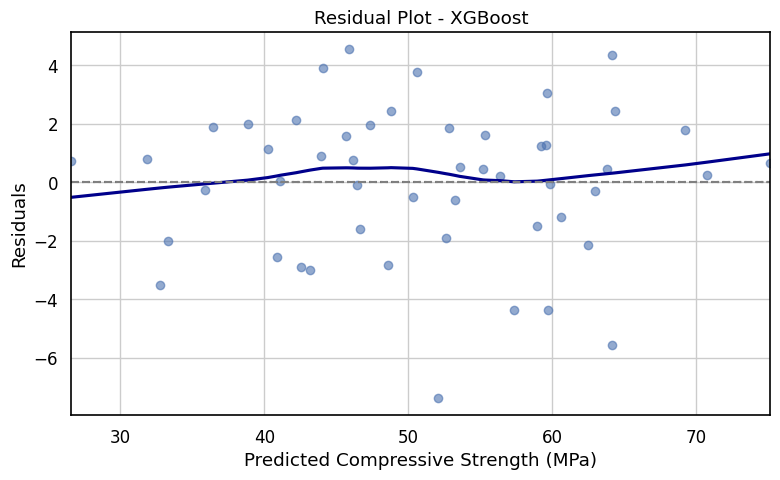

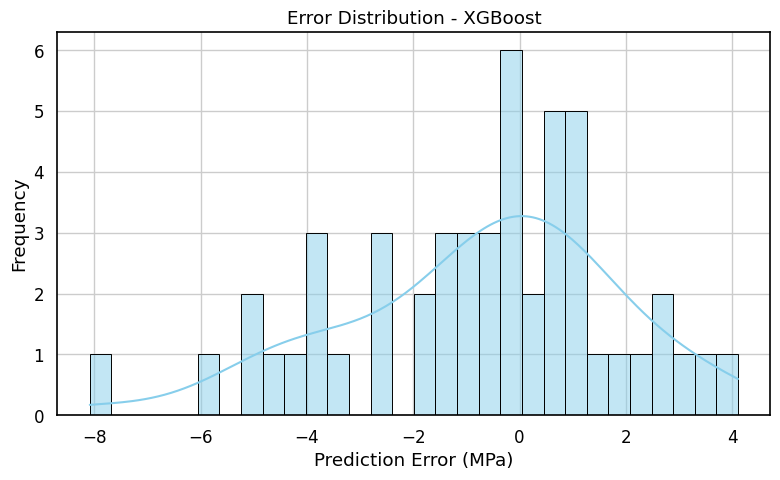

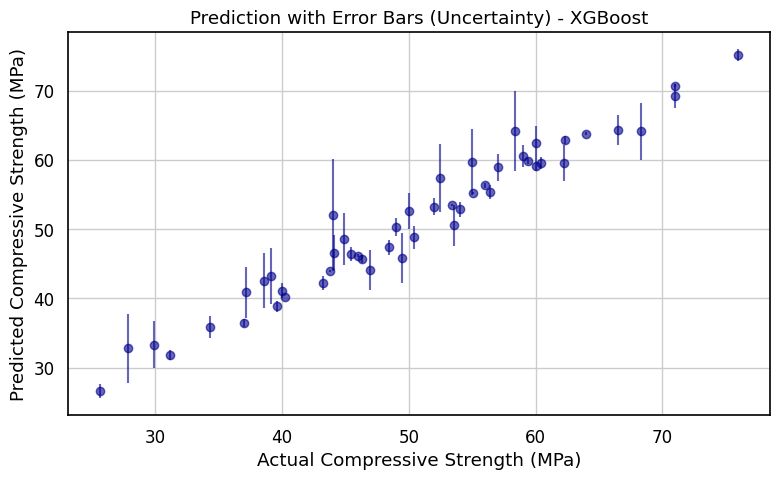

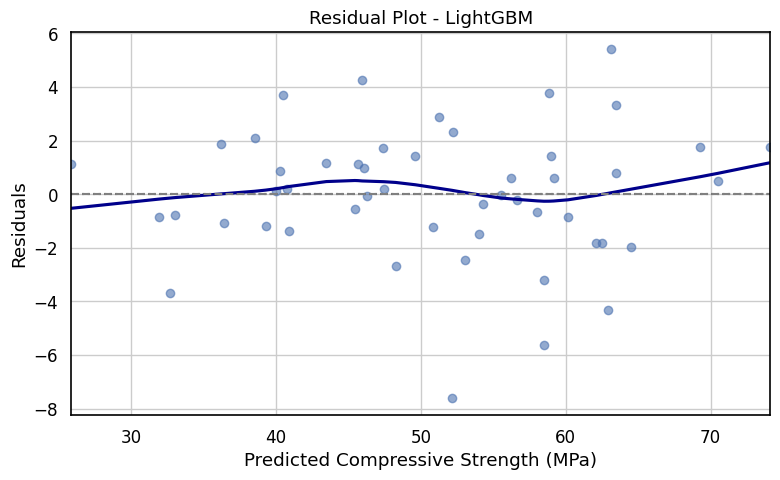

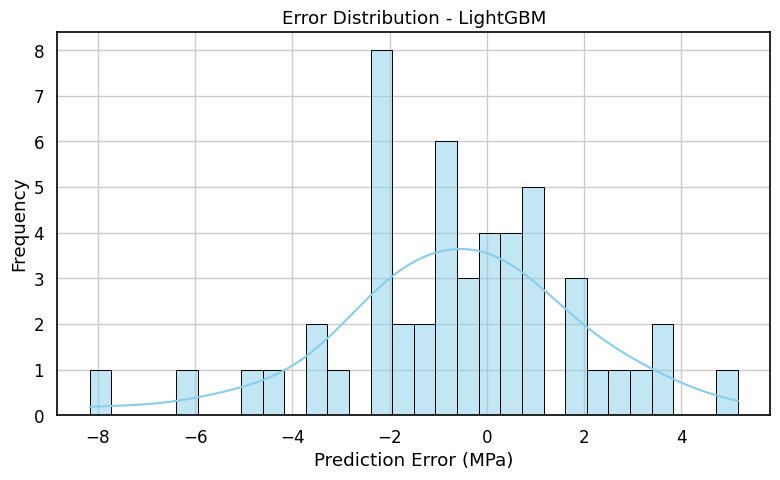

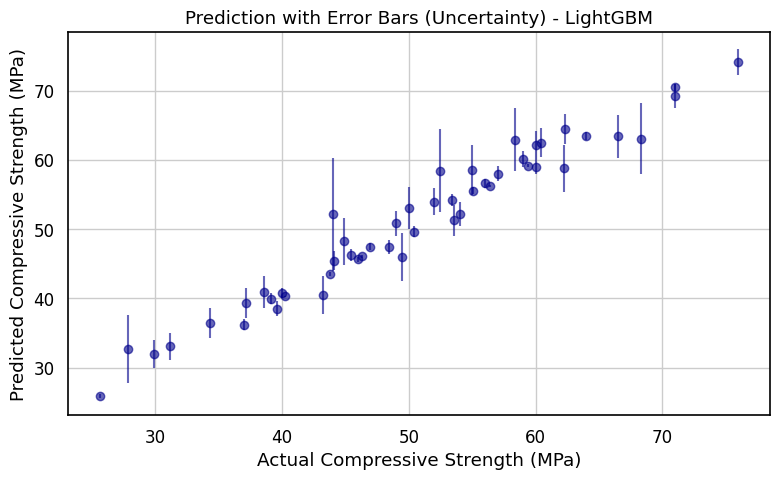

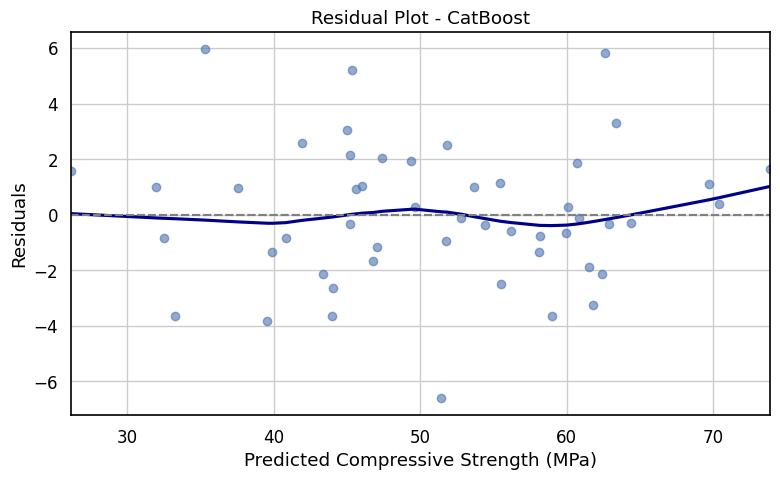

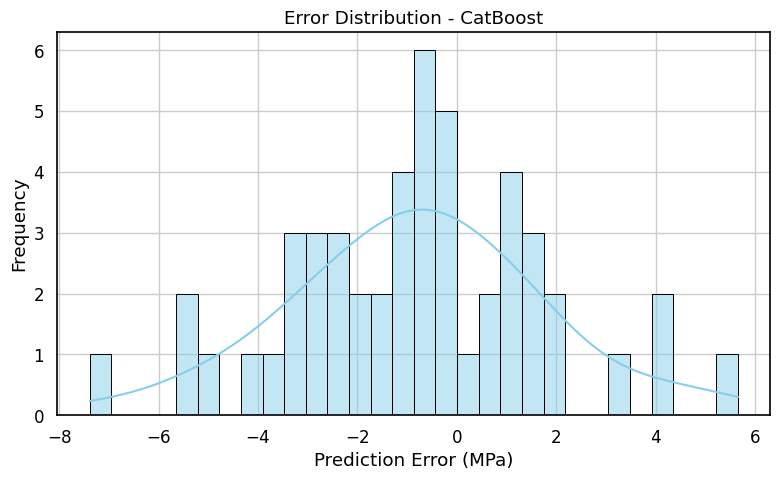

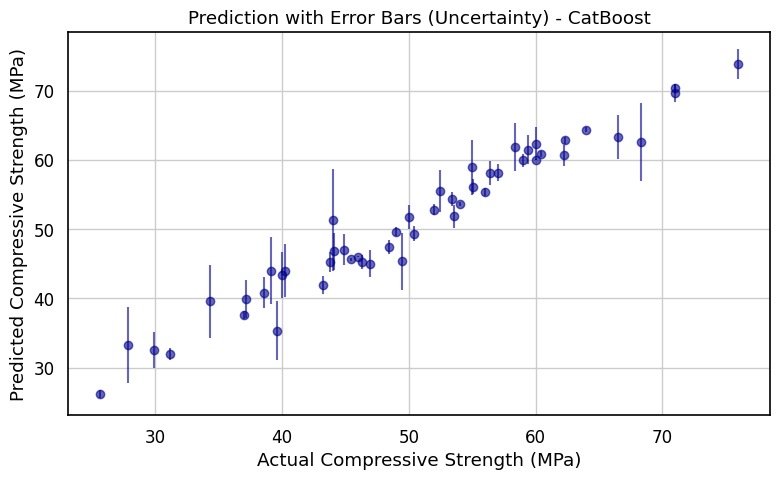

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Iterate over each model and generate residual/error plots
for model_name, result in results.items():
    best_model = result["Best Model"]

    # For Hybrid model, special prediction path
    if model_name == "Hybrid XGB-LGB":
        xgb_preds_test = results["XGBoost"]["Best Model"].predict(X_test).reshape(-1, 1)
        y_pred = best_model.predict(xgb_preds_test)
    else:
        y_pred = best_model.predict(X_test)

    residuals = y_test - y_pred
    errors = residuals

    # 1. Residual Plot with LOWESS
    plt.figure(figsize=(8, 5))
    ax1 = sns.residplot(x=y_pred, y=residuals, lowess=True,
                        scatter_kws={'alpha': 0.6}, line_kws={'color': 'darkblue'})
    plt.axhline(y=0, color='gray', linestyle='--')
    ax1.set_title(f"Residual Plot - {model_name}", color='black')
    ax1.set_xlabel("Predicted Compressive Strength (MPa)", color='black')
    ax1.set_ylabel("Residuals", color='black')
    ax1.tick_params(colors='black')
    ax1.grid(True)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)
    plt.tight_layout()
    plt.show()

    # 2. Error Distribution Histogram
    plt.figure(figsize=(8, 5))
    ax2 = sns.histplot(residuals, bins=30, kde=True, color="skyblue", edgecolor='black', linewidth=0.7)
    ax2.set_title(f"Error Distribution - {model_name}", color='black')
    ax2.set_xlabel("Prediction Error (MPa)", color='black')
    ax2.set_ylabel("Frequency", color='black')
    ax2.tick_params(colors='black')
    ax2.grid(True)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)
    plt.tight_layout()
    plt.show()

    # 3. Prediction with Error Bars (Uncertainty)
    fig, ax3 = plt.subplots(figsize=(8, 5))
    ax3.errorbar(y_test, y_pred, yerr=np.abs(errors), fmt='o', alpha=0.6, color='darkblue')
    ax3.set_title(f"Prediction with Error Bars (Uncertainty) - {model_name}", color='black')
    ax3.set_xlabel("Actual Compressive Strength (MPa)", color='black')
    ax3.set_ylabel("Predicted Compressive Strength (MPa)", color='black')
    ax3.tick_params(colors='black')
    ax3.grid(True)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)
    plt.tight_layout()
    plt.show()

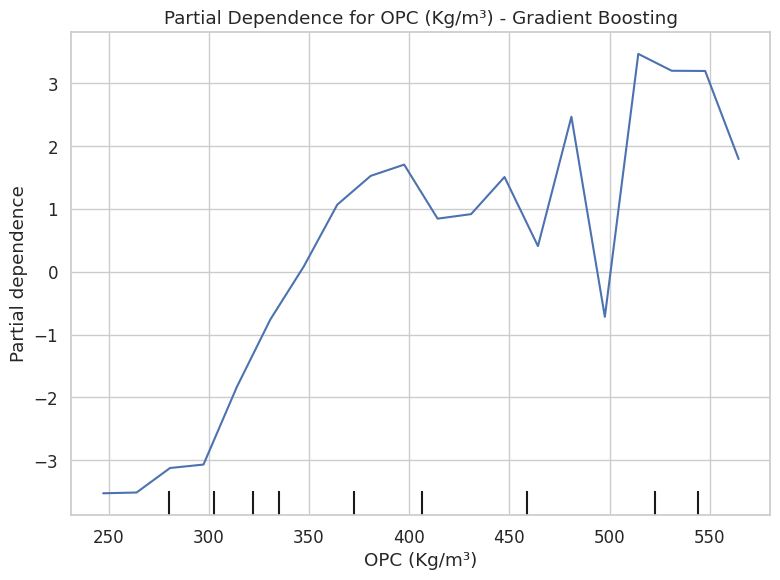

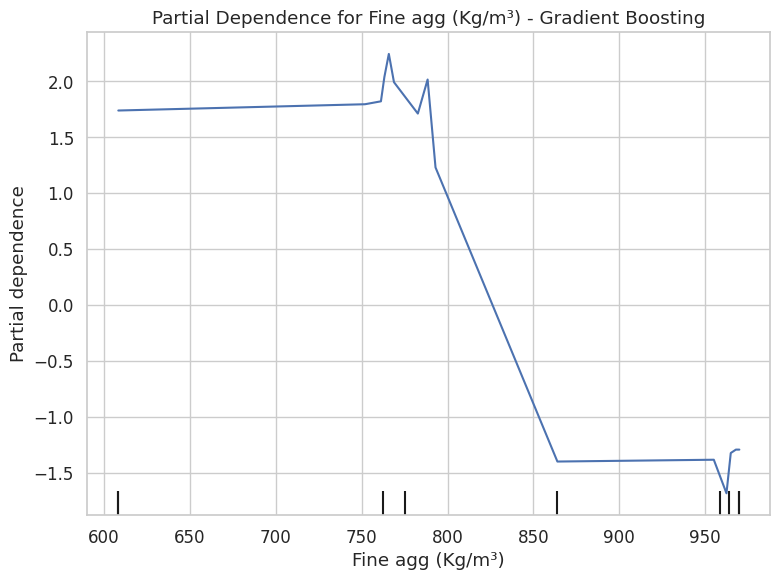

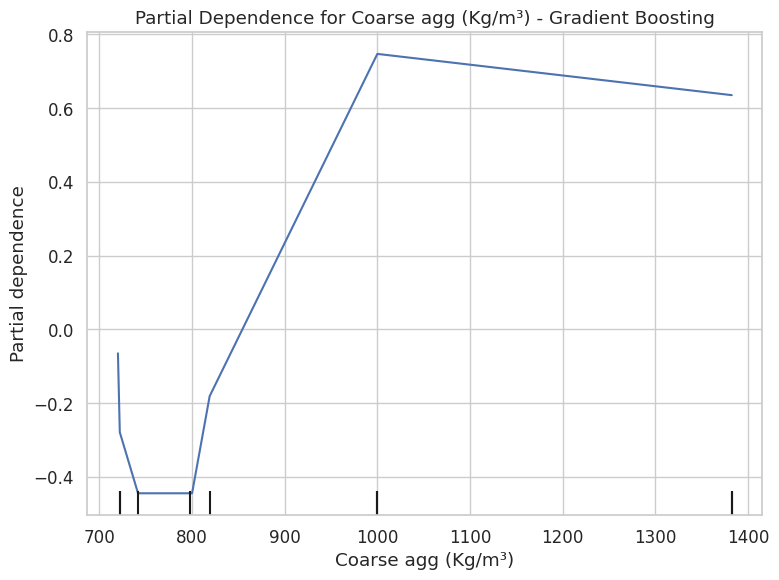

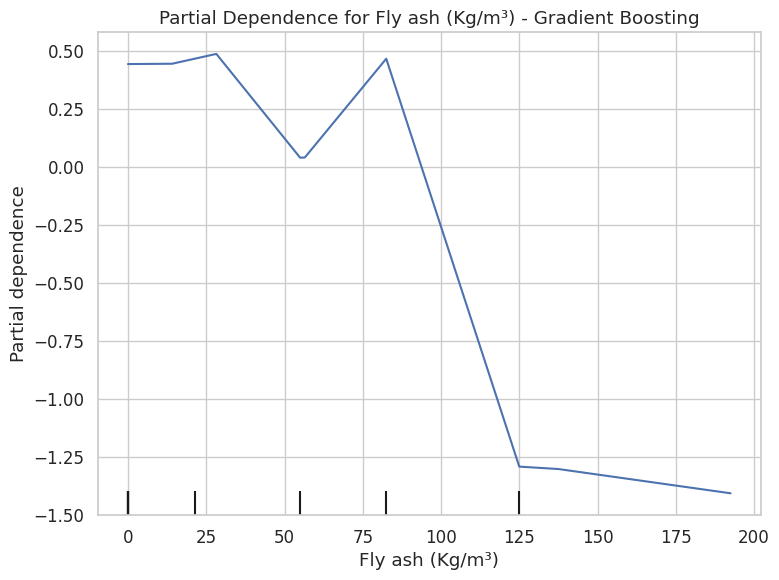

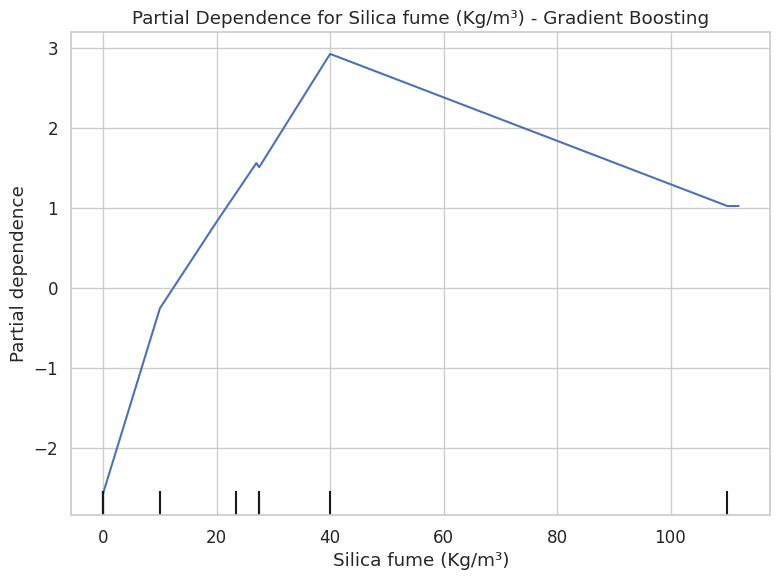

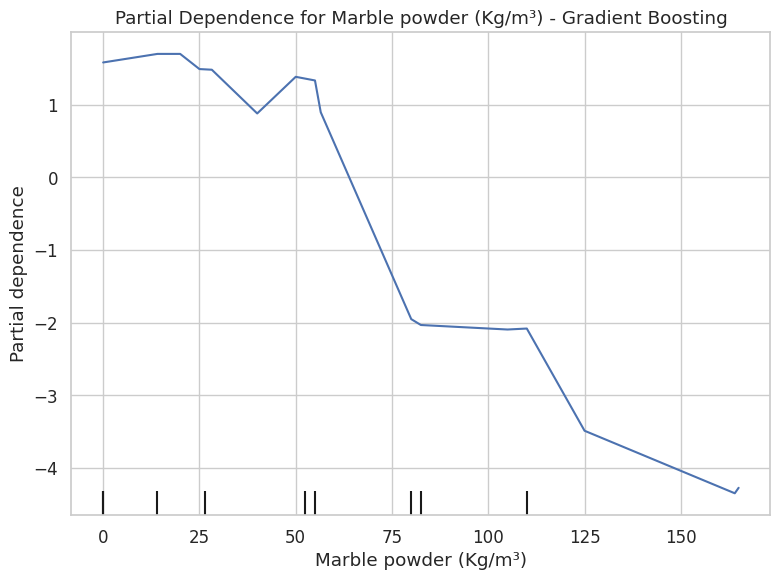

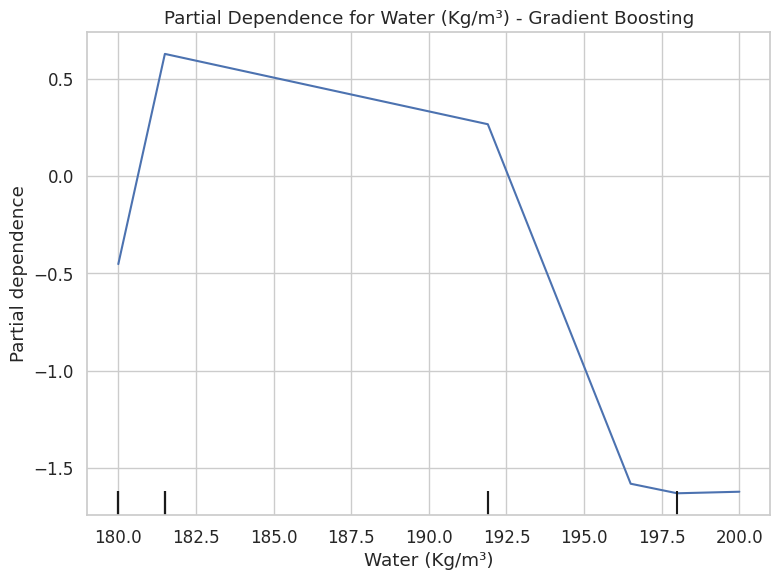

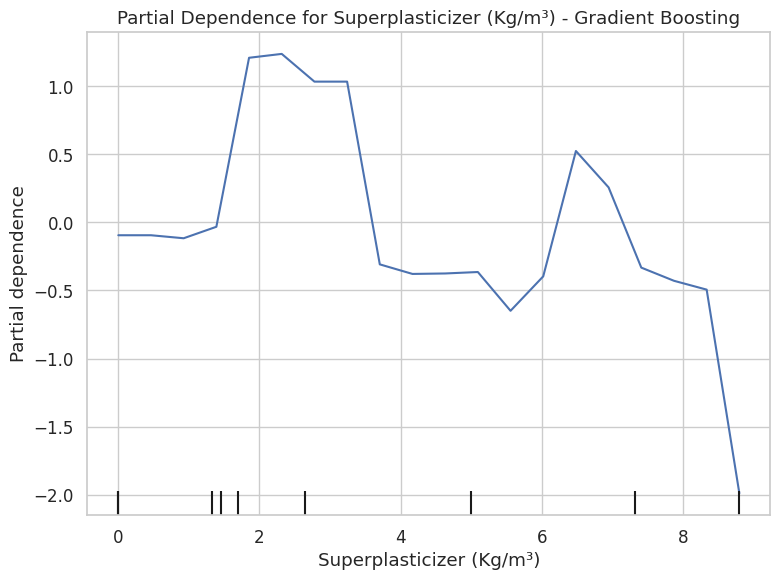

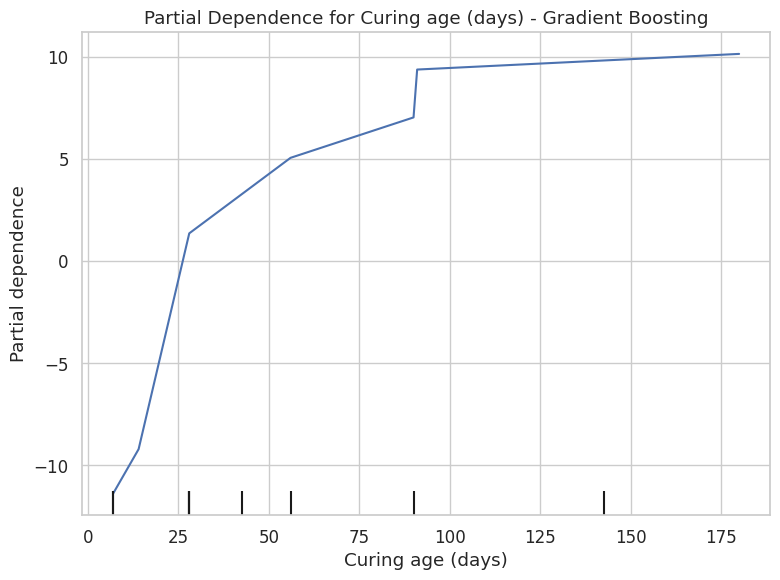

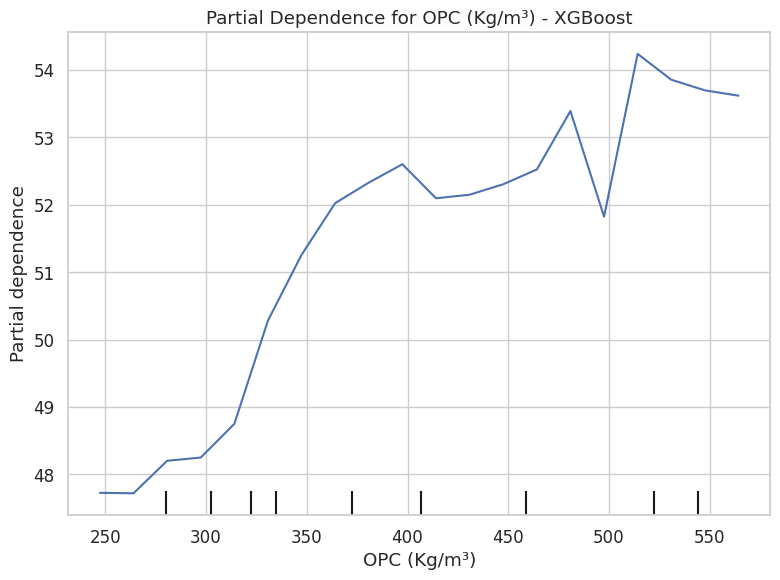

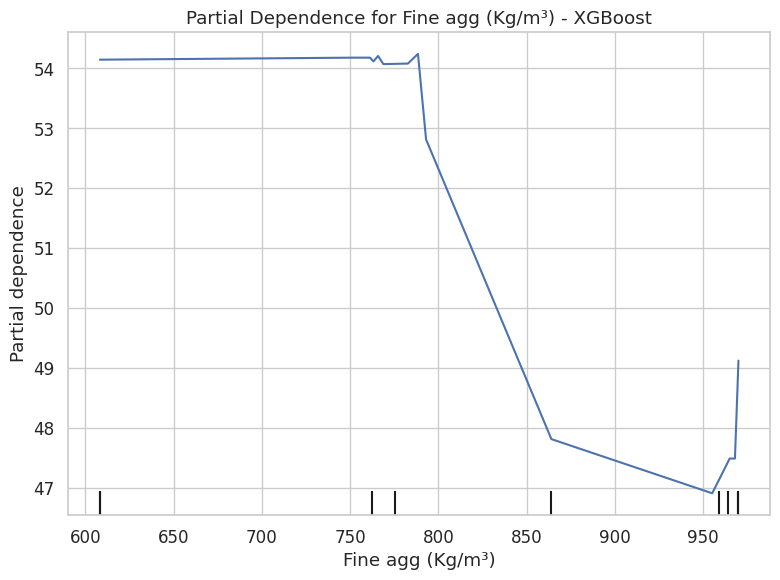

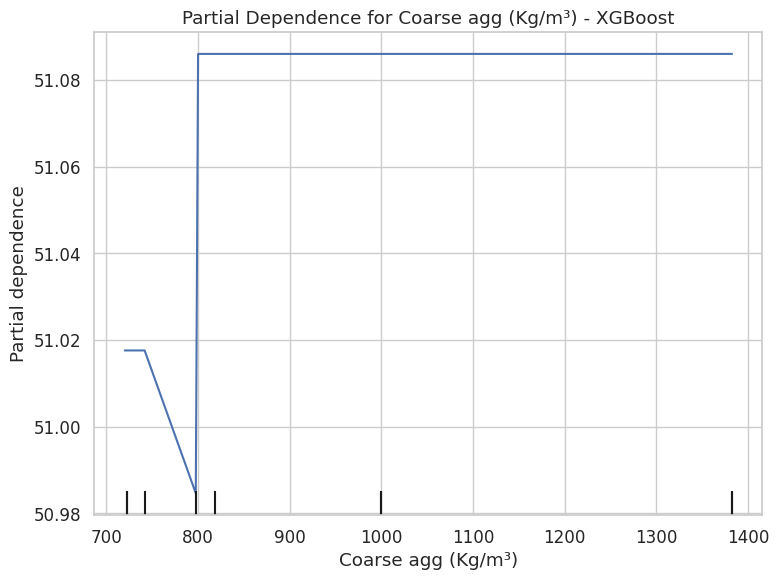

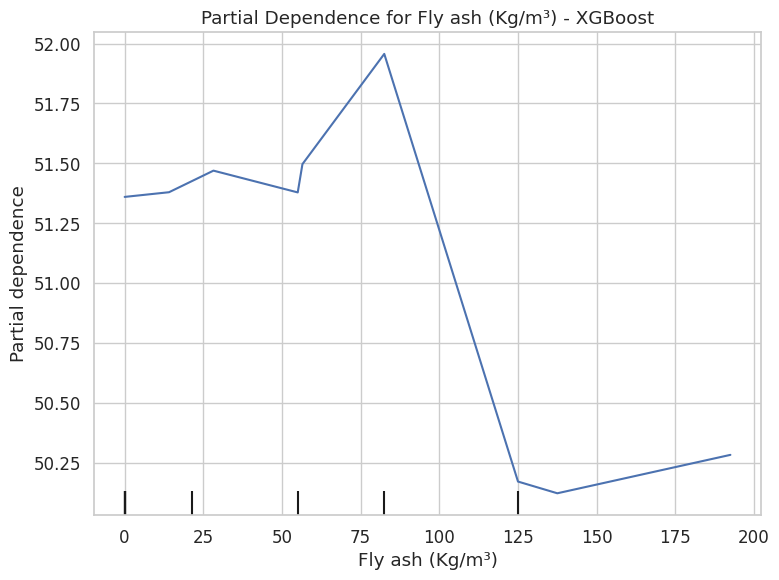

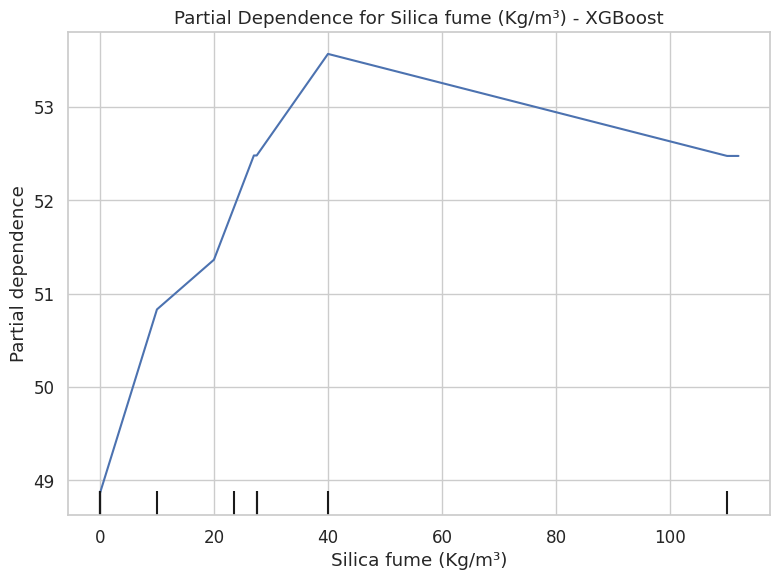

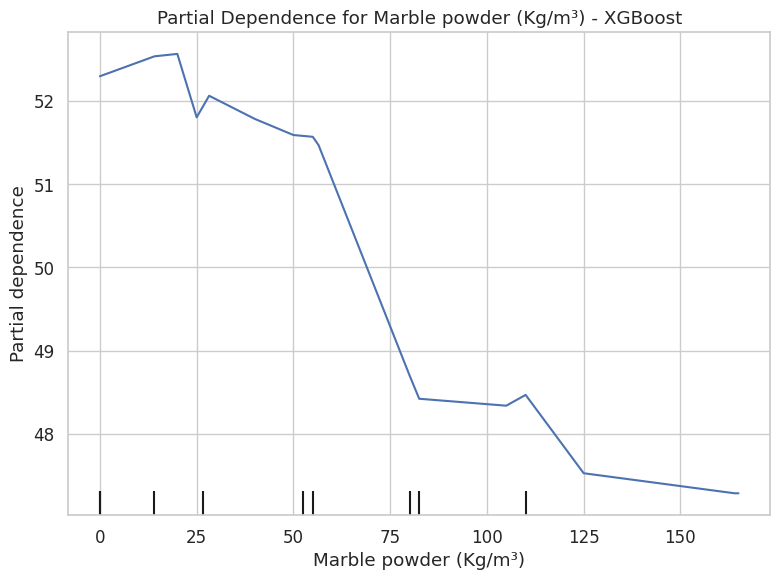

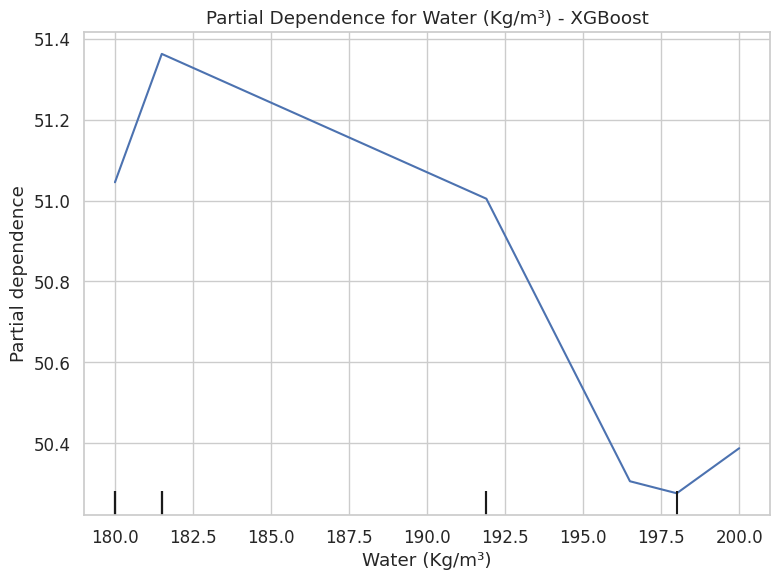

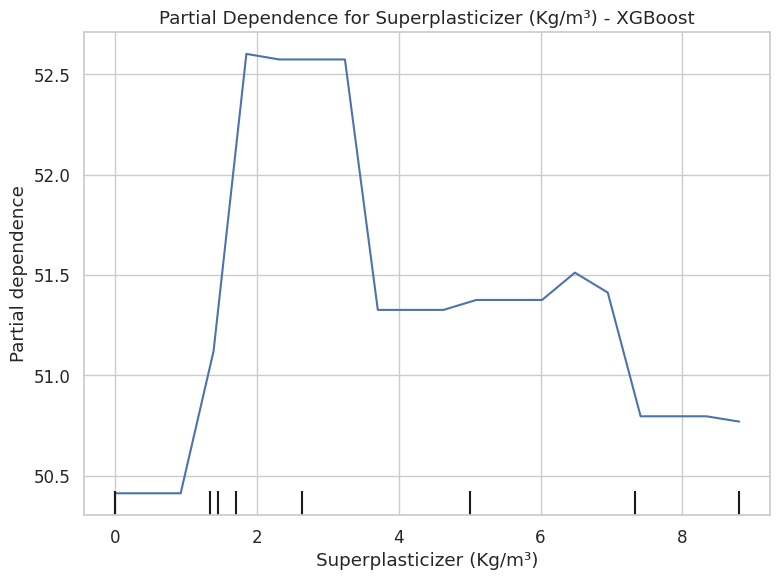

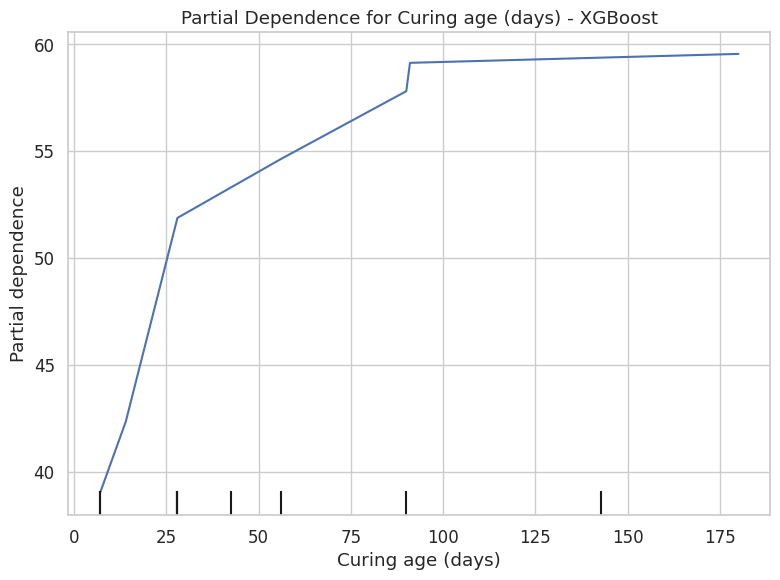

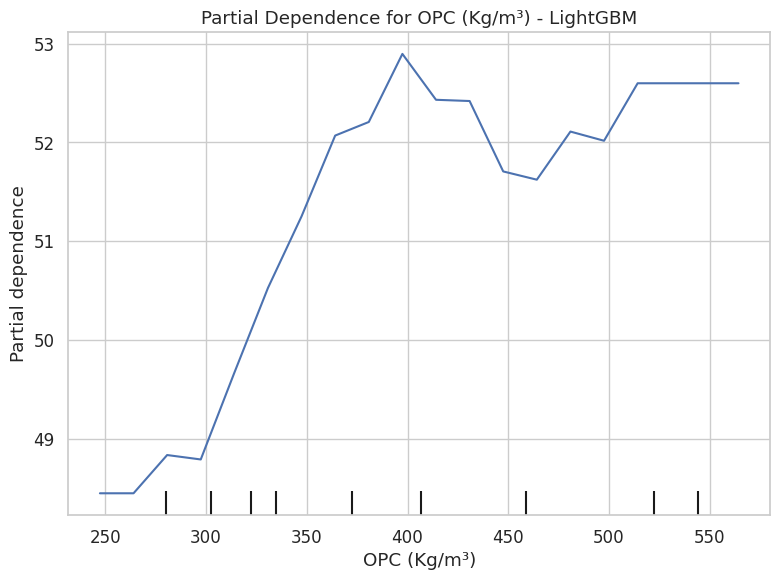

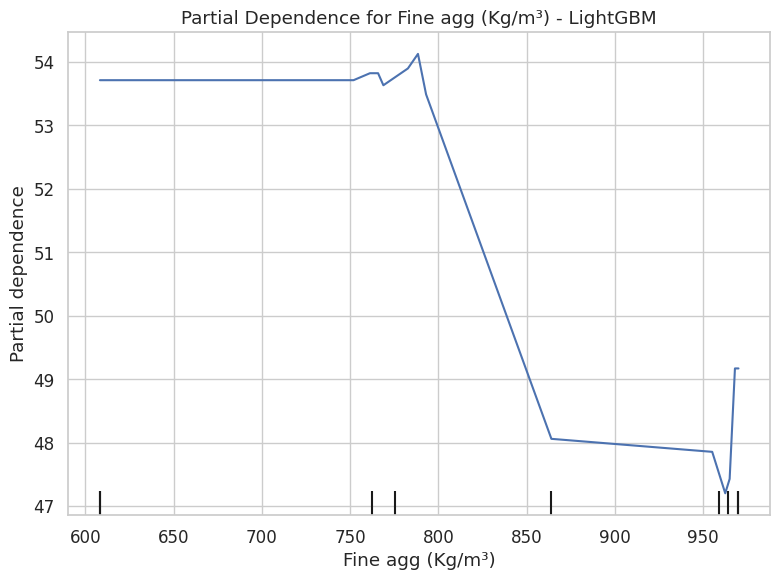

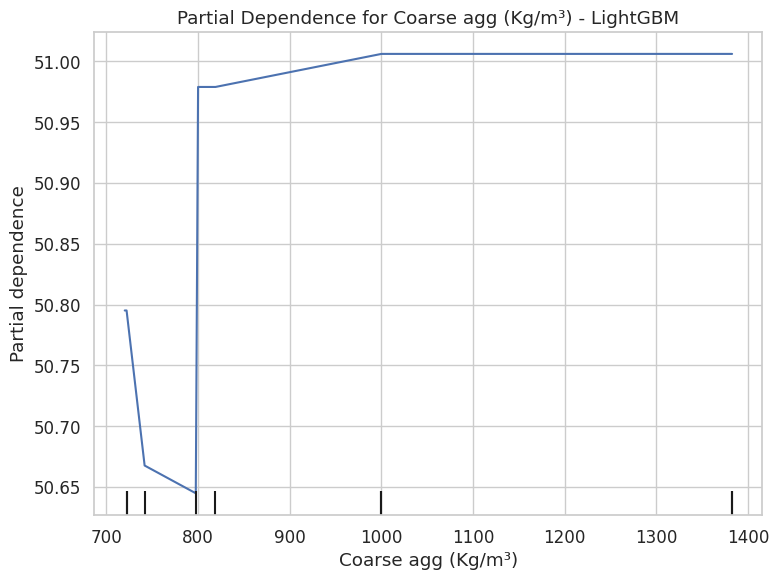

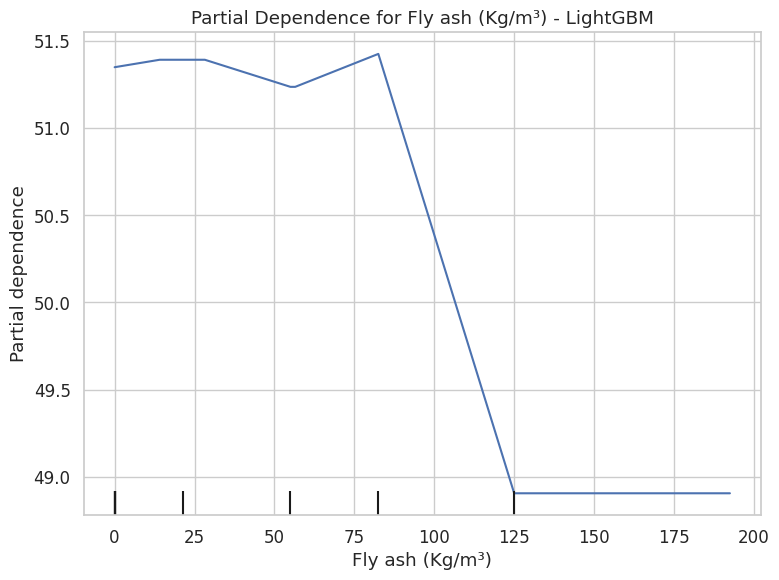

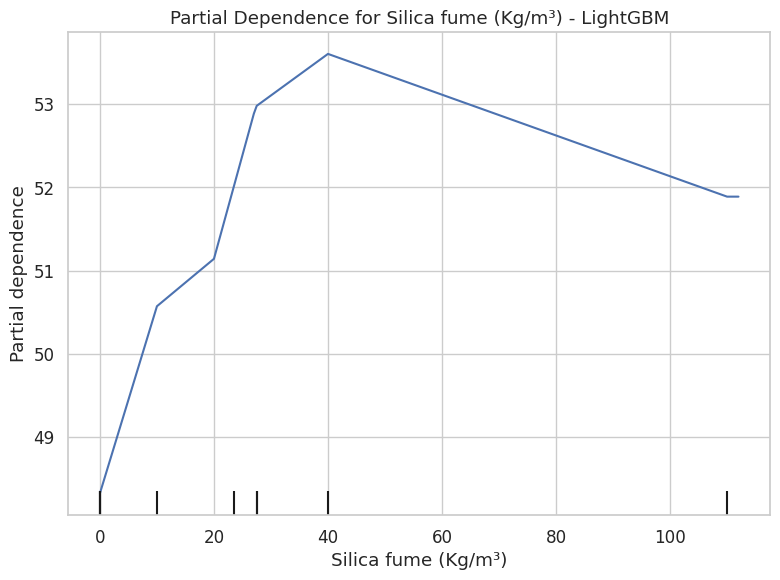

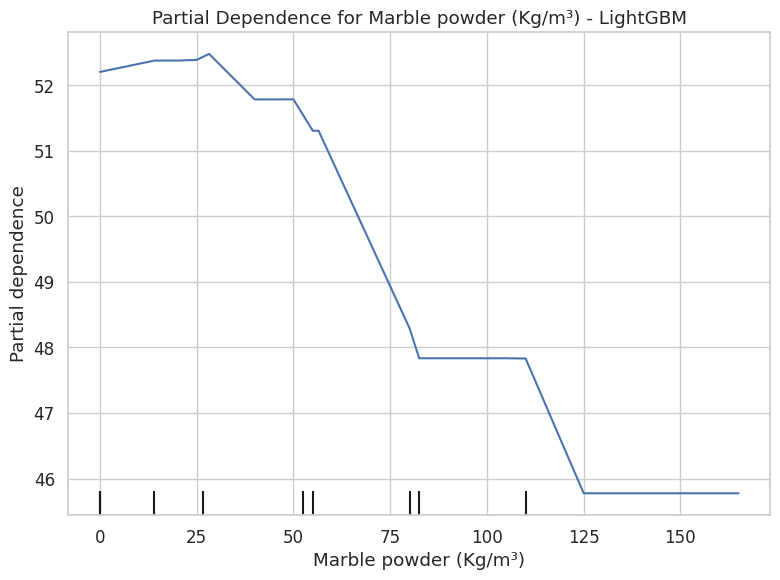

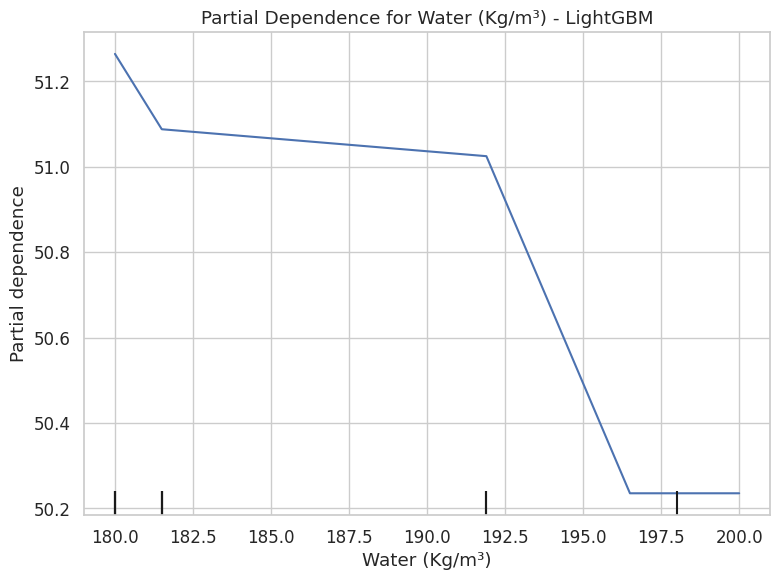

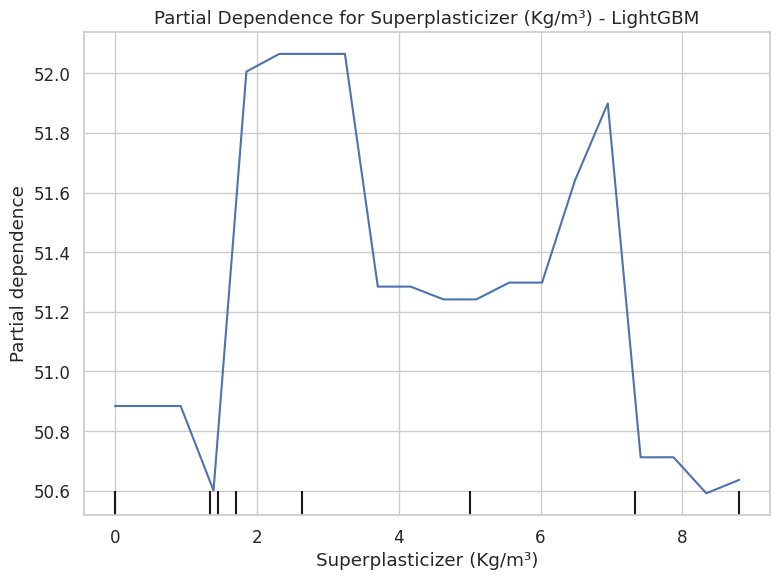

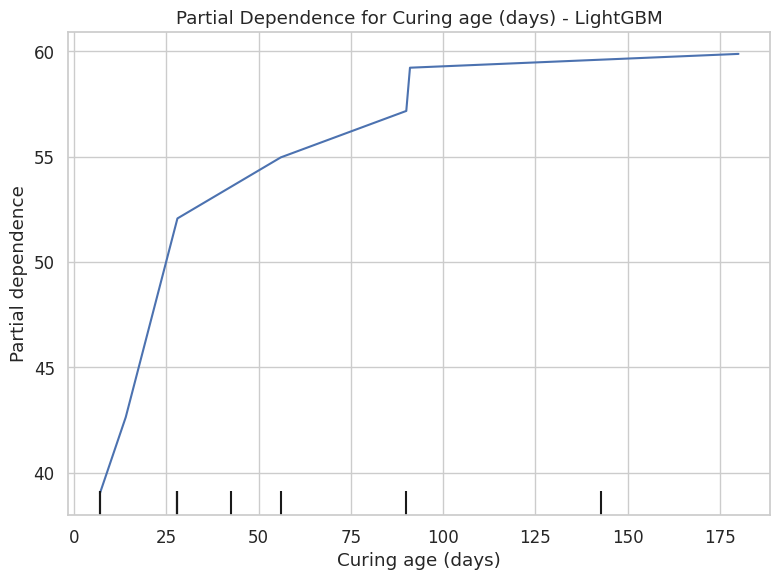

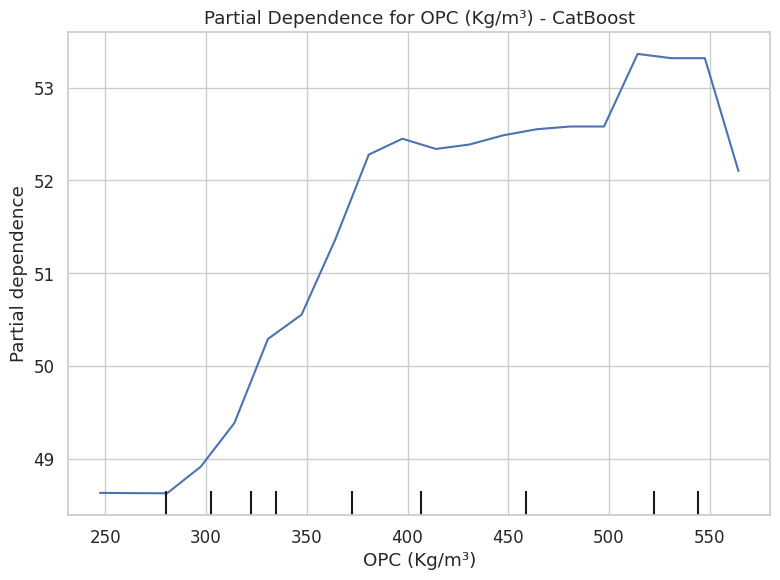

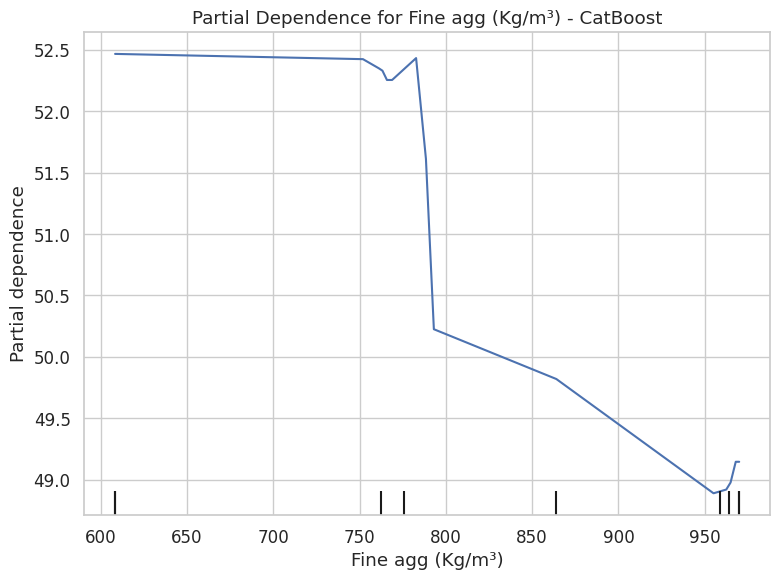

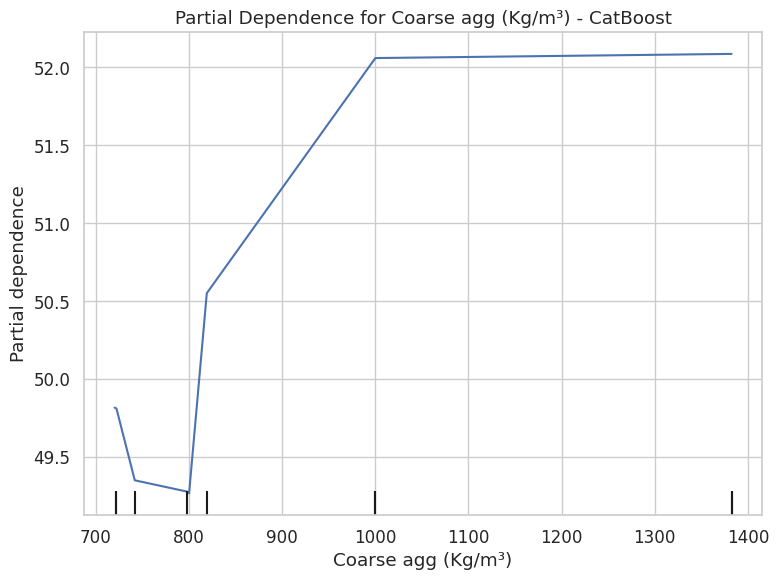

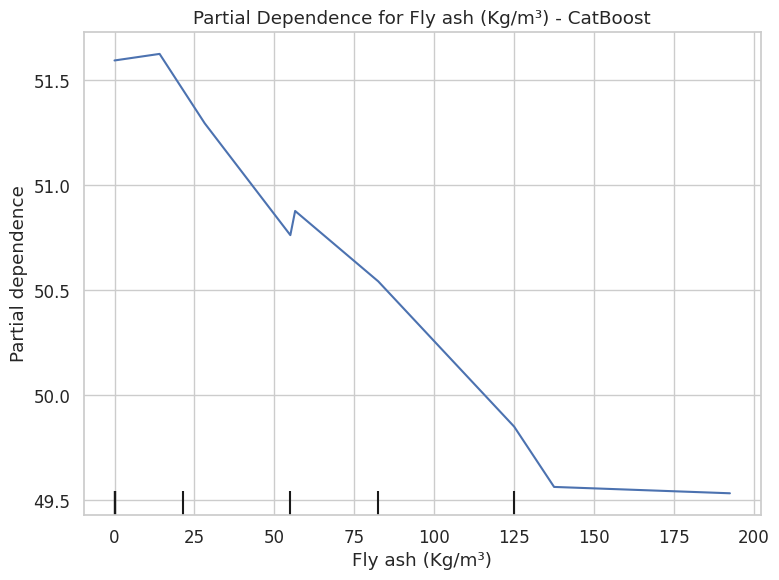

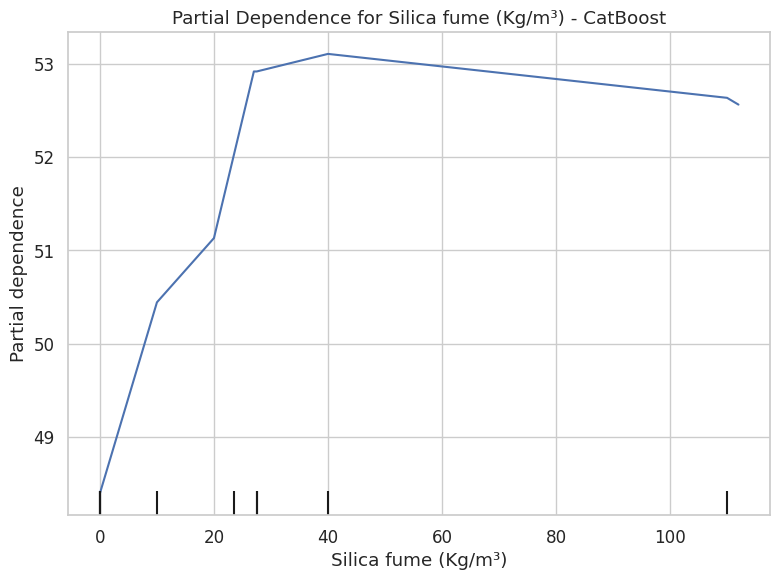

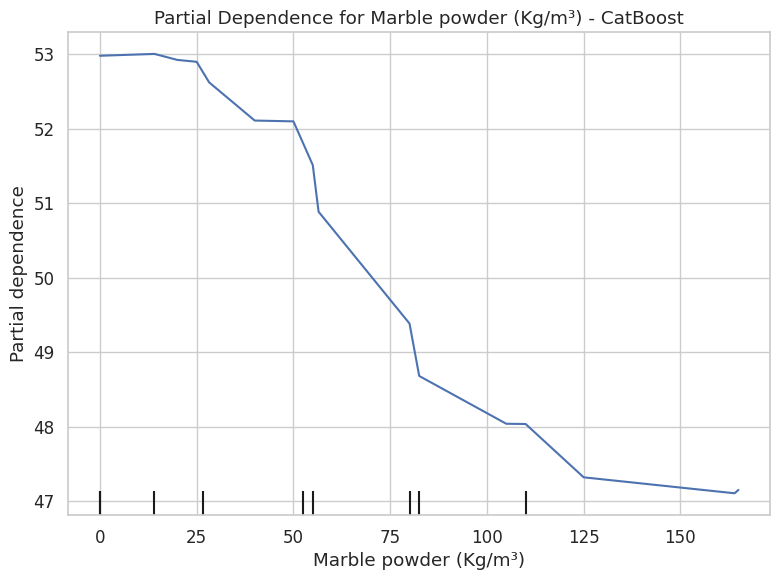

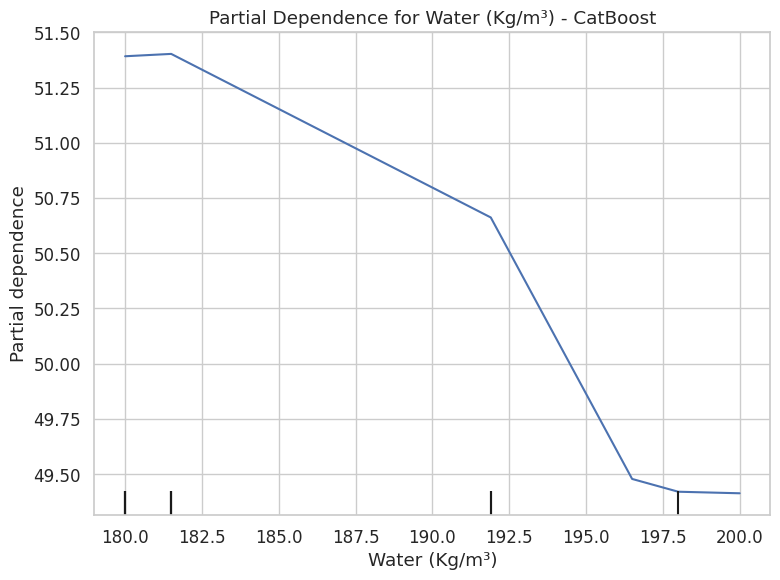

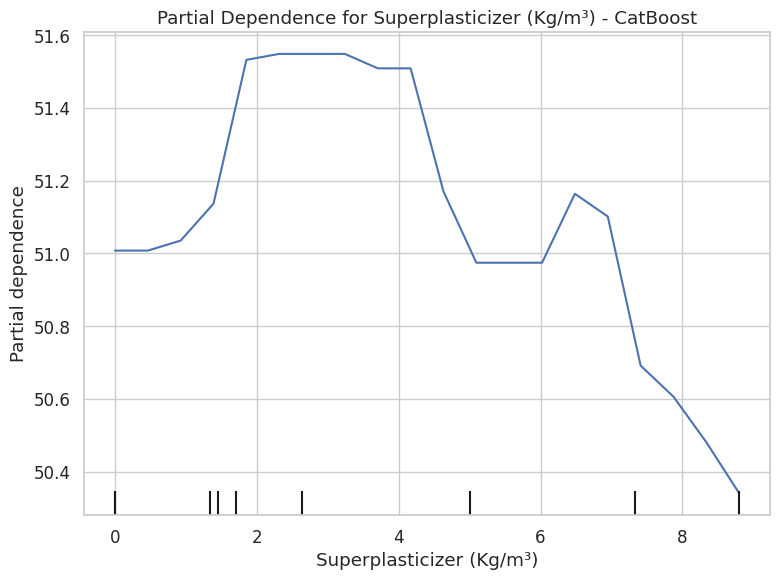

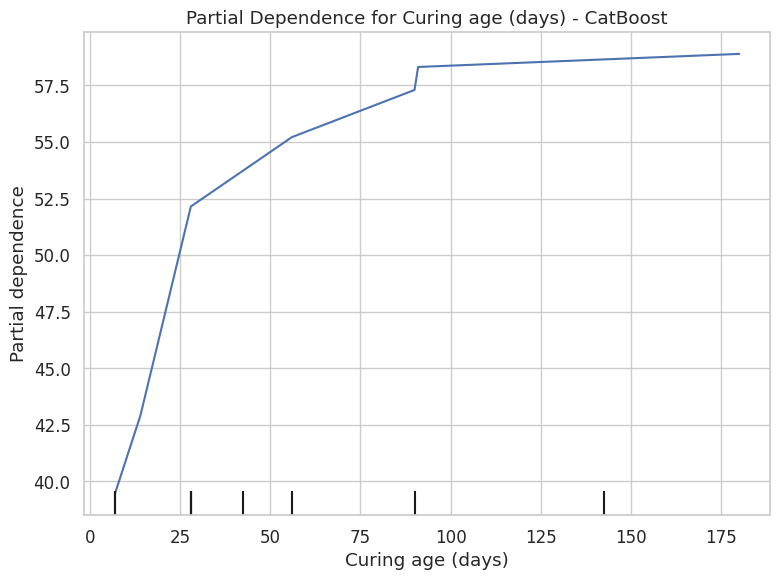

In [88]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import time

# List of feature names
features = [
    'OPC (Kg/m³)', 'Fine agg (Kg/m³)', 'Coarse agg (Kg/m³)',
    'Fly ash (Kg/m³)', 'Silica fume (Kg/m³)', 'Marble powder (Kg/m³)',
    'Water (Kg/m³)', 'Superplasticizer (Kg/m³)', 'Curing age (days)'
]

# Use only selected features for X_test
X_test_selected = X_test[features]

# Standard models
standard_models = {
    "Gradient Boosting": results["Gradient Boosting"]["Best Model"],
    "XGBoost": results["XGBoost"]["Best Model"],
    "LightGBM": results["LightGBM"]["Best Model"],
    "CatBoost": results["CatBoost"]["Best Model"]
}

# Plot with visual separation
for model_name, model in standard_models.items():
    for feature in features:
        feature_idx = X.columns.get_loc(feature)
        fig, ax = plt.subplots(figsize=(8, 6))
        PartialDependenceDisplay.from_estimator(
            estimator=model,
            X=X_test_selected,
            features=[feature_idx],
            grid_resolution=20,
            ax=ax
        )
        ax.set_title(f"Partial Dependence for {feature} - {model_name}")
        plt.tight_layout()
        plt.show()

        print("\n")
        time.sleep(0.5)

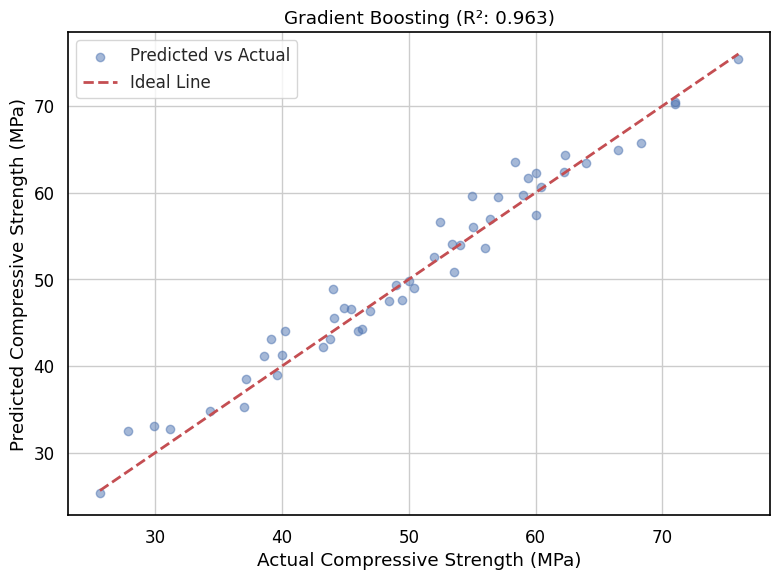

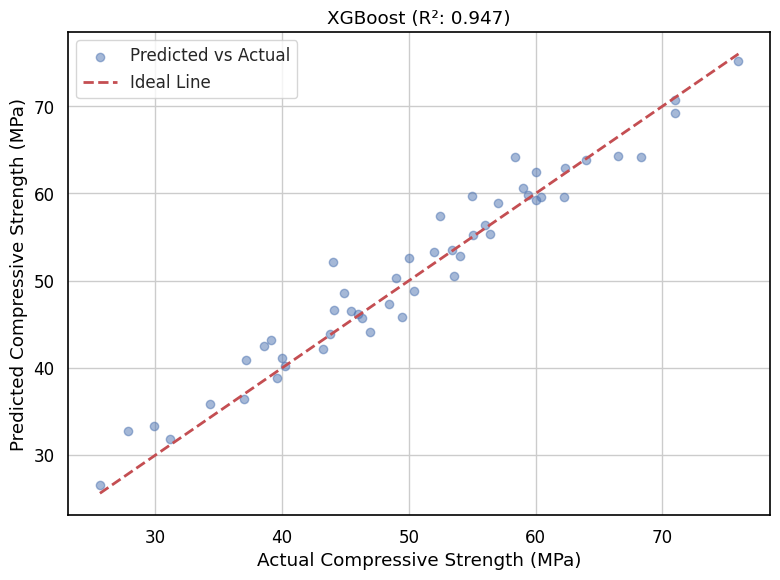

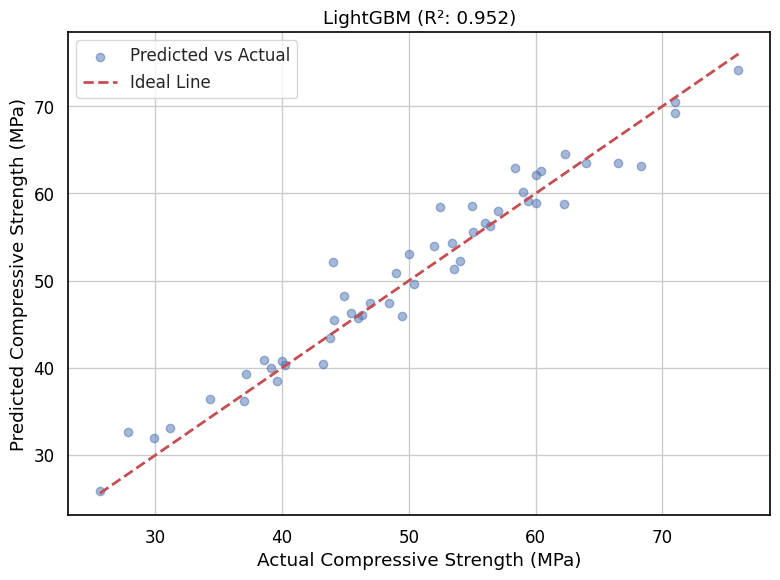

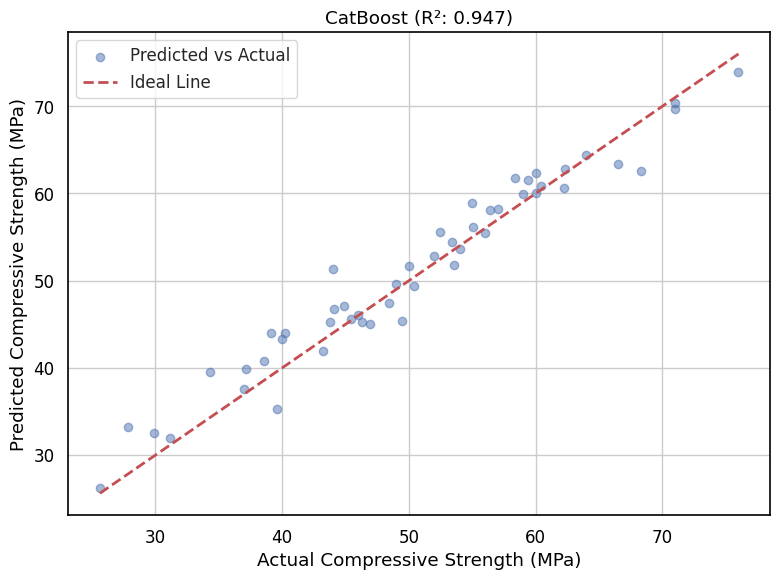

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_actual_vs_predicted(X_test, y_test, results):
    for model_name in results:
        best_model = results[model_name]['Best Model']

        y_pred = best_model.predict(X_test)

        # Create a new figure for each model
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Line')
        plt.xlabel('Actual Compressive Strength (MPa)', color='black')
        plt.ylabel('Predicted Compressive Strength (MPa)', color='black')
        plt.title(f'{model_name} (R²: {results[model_name]["R² Score"]:.3f})', color='black')
        plt.legend()
        plt.grid(True)
        plt.tick_params(colors='black')

        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.2)

        plt.tight_layout()
        plt.show()

        print("\n")

plot_actual_vs_predicted(X_test, y_test, results)

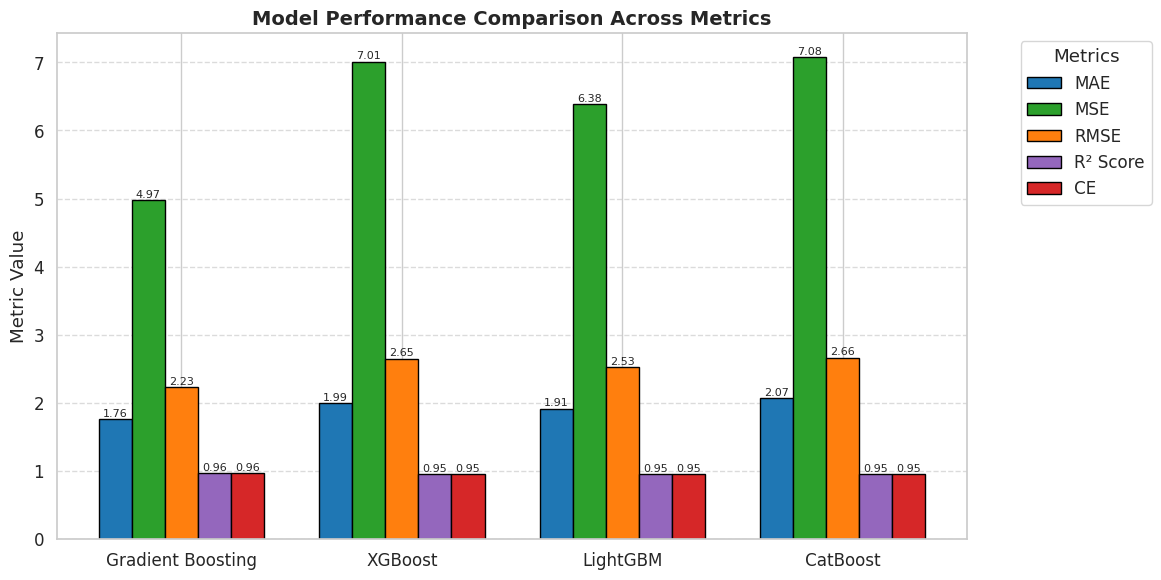

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(14, 6))
metrics = ['MAE', 'MSE', 'RMSE', 'R² Score', 'CE']
n_models = len(results_df)
x = np.arange(n_models)
width = 0.15

colors = [
    '#1f77b4',
    '#2ca02c',
    '#ff7f0e',
    '#9467bd',
    '#d62728'
]

for i, (metric, color) in enumerate(zip(metrics, colors)):
    plt.bar(x + (i - 2) * width, results_df[metric], width, label=metric, color=color, edgecolor='black')

for i in range(n_models):
    for j, metric in enumerate(metrics):
        value = results_df[metric].iloc[i]
        plt.text(x[i] + (j - 2) * width, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.xticks(x, results_df.index, rotation=0, ha='center')
plt.ylabel('Metric Value')
plt.title('Model Performance Comparison Across Metrics', fontsize=14, weight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


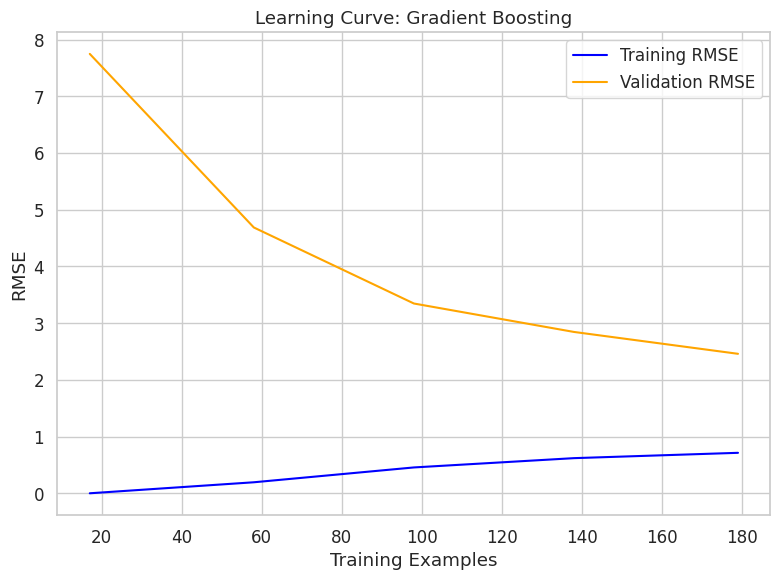

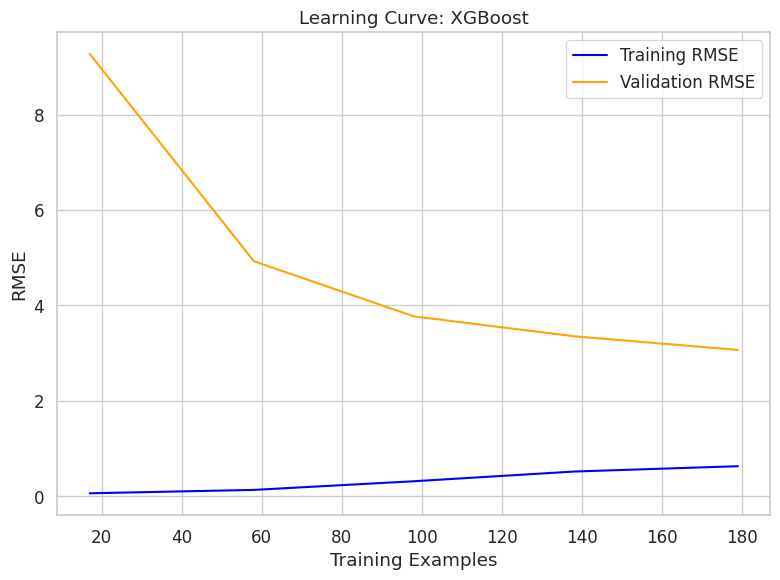

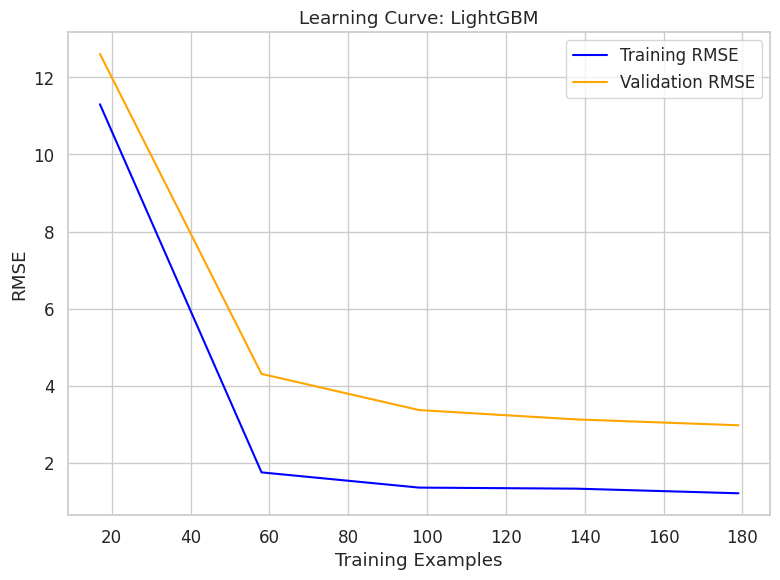

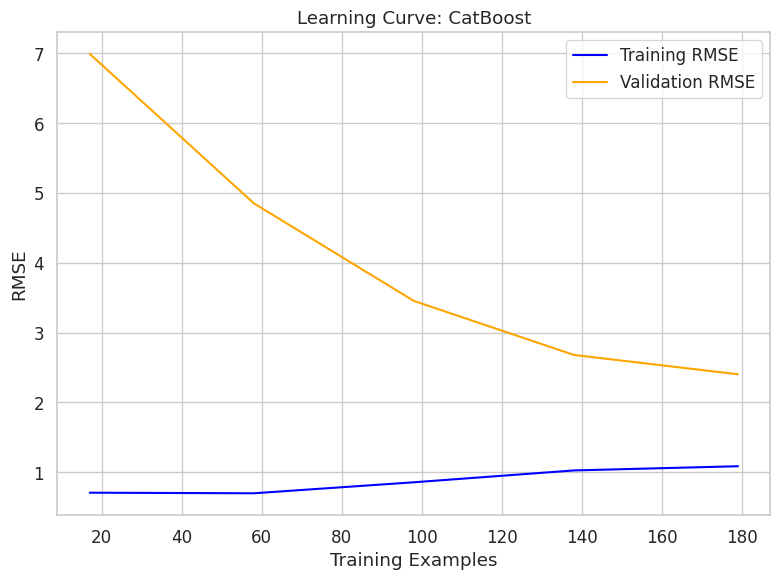

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curves_separately(results, results_df, X_train, y_train):
    for model_name in results_df.index:
        model = results[model_name]['Best Model']

        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train, y_train, cv=10,
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        train_scores_mean = np.sqrt(-train_scores.mean(axis=1))
        val_scores_mean = np.sqrt(-val_scores.mean(axis=1))

        # Create a new plot for each model
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_scores_mean, label='Training RMSE', color='blue')
        plt.plot(train_sizes, val_scores_mean, label='Validation RMSE', color='orange')
        plt.title(f'Learning Curve: {model_name}')
        plt.xlabel('Training Examples')
        plt.ylabel('RMSE')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print("\n")

plot_learning_curves_separately(results, results_df, X_train, y_train)